# **DataLab Cup 2: CNN for Object Detection**

### **Team Member:** 108024507 張文騰 / 108024512 吳紹丞 / 108024519 劉怡禎 / 109062659 蘇瑞揚

# ***Content (4 sections):***
## 1. **Image Balancing / Augmentation**: output the Image to ensure all the images were correctly augmented and the bounding boxes are correctly located.
## 2. **Image Balancing / Augmentation**: through Tensorflow pipeline / data generator
## 3. **Model Building**
## 4. **Sharings and Conclusions**

#### Note that the difference between 1 and 2 is that 1 directly inputs the image through the pipeline (preprocessing and augmentation) to the model, 2 outputs the proper images so that no further preprocessing / augmentation required during the process of inputting the images to the model. 

# ***1. Image Balancing / Augmentation and output the Images***

## Agenda:
### 0. **Import Packages and set up GPU**
### 1. **Before Augmentation**: Balance the data
### 2. **After Augmentation**: Check if the images are correctly balanced and augmented. (We show the final augmented result first for providing you a big picture of what we had done in the next sub-section (3. During Augmentation).) 
### 3. **During Augmentation**: A data augmentation class is built and the methods applied inside the class are broken down in each chunk and will be elaborated clearly.

## 0. Import Packages and set up GPU

### Import Packages

In [ ]:
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import math
from sklearn.cluster import AgglomerativeClustering

### Connect to the GPU Server and limit the usage if needed

In [ ]:
# limit the uasge of memory
import tensorflow as tf
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "1"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
    except RuntimeError as e:
        print(e)

## 1. Before Augmentaion: Data Balancing

### ***Firstly, let's explore the distribution of the original dataset, we can see that class 14(person) is an extreme outlier.***

In [ ]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

# common params
IMAGE_SIZE = 448
NUM_CLASSES = 10
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './pascal_voc_training_data.txt'
IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages/'

In [ ]:
# path = "/home/statgpu1/108024507/Competition2_Object_Detection/"
path = "/home/ingmember03/DL2020/DL2020_07/"

os.chdir(path)

training_data_label = open("./pascal_voc_training_data.txt", "r")

def check_MAX_OBJECTS_PER_IMAGE(num):
    idx_over_MAX_OBJECTS_PER_IMAGE = []
    for idx, label in enumerate(training_data_label):
        if len(label.strip().split()) > num*5+1:
            idx_over_MAX_OBJECTS_PER_IMAGE.append(idx)
    return (idx, idx_over_MAX_OBJECTS_PER_IMAGE)

idx, idx_over_MAX_OBJECTS_PER_IMAGE = check_MAX_OBJECTS_PER_IMAGE(MAX_OBJECTS_PER_IMAGE)

print("Total Training Data:", idx+1)
print("Object Detected > max_object: ", len(idx_over_MAX_OBJECTS_PER_IMAGE))
print("Object Detected > max_object: (e.g.)", idx_over_MAX_OBJECTS_PER_IMAGE[0:5])

Total Training Data: 4974
Object Detected > max_object:  18
Object Detected > max_object: (e.g.) [304, 366, 674, 723, 1479]


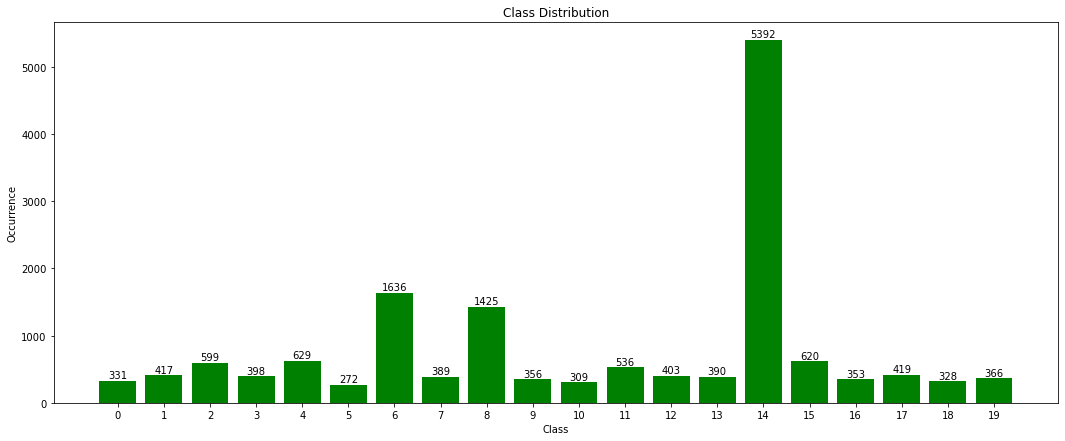

In [ ]:
def createBarLabels(barplot):
    for item in barplot:
        plt.text(
            item.get_x()+item.get_width()/2., 
            item.get_height()*1.005, 
            '%d' % int(item.get_height()),
            ha = "center",
            va = "bottom",
        )

def balanced_label(data):

    label_dist = []
    for i, label_line in enumerate(data):
            label_line = label_line.strip().split()
            label_line = label_line[1:]
            length = len(label_line)//5
            for j in range(length):
                label_dist.append(label_line[j*5+4])

    label_class_dist = []

    for i, classi in enumerate(range(20)):
        label_class_dist.append((str(i), label_dist.count(str(classi))))

    return(label_class_dist)

training_data_label = open("./pascal_voc_training_data.txt", "r")
label_class_dist = balanced_label(training_data_label)

plt.figure(figsize=(18,7))
A = plt.bar(list(zip(*label_class_dist))[0],list(zip(*label_class_dist))[1], color = 'green')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Occurrence')
createBarLabels(A)

### ***Secondly, let's conduct kMeans clustering to cluster dataset into 20 clusters. We apply Cosine Distance as the distance measure to make sure each cluster only includes a specific class.***

In [ ]:
training_data_label = open("./pascal_voc_training_data.txt", "r")

# transform file to dict format
label_dist_with_idx = {}
image_name = []

for idx, label_line in enumerate(training_data_label):
    label_line_temp = []
    label_line = label_line.strip().split()
    image_name.append(label_line[0])
    label_dist_with_idx[image_name[idx]] = []
    label_line_no_first = label_line[1:]
    length = len(label_line)//5
    for i in range(1,length+1,1):
        label_line_temp.append(label_line_no_first[i*5-1])
    label_dist_with_idx[image_name[idx]] = label_line_temp

image_matrix_for_cluster = []
# Count Object in each image for clustering
for image in image_name:
    for classi in range(len(classes_name)):
        image_matrix_for_cluster.append(label_dist_with_idx[image].count(str(classi)))

# transform to np.array
np_image_matrix_for_cluster = np.array(image_matrix_for_cluster).reshape([len(image_name),len(classes_name)])

### Here we are, we can see that each class dominates its own cluster.

Total Images: 4974


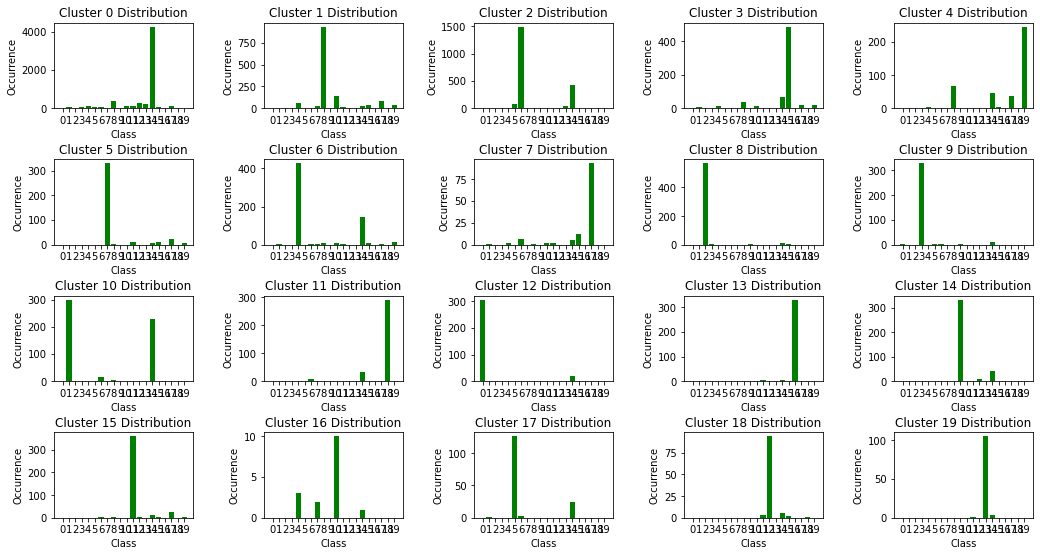

In [ ]:
path = "/home/ingmember03/DL2020/DL2020_07/"

cluster_num = 20
cluster = AgglomerativeClustering(n_clusters = cluster_num, affinity = 'cosine', linkage = 'complete')
cluster.fit_predict(np_image_matrix_for_cluster)

# count the images in each cluster

cluster_labels_uni, counts = np.unique(cluster.labels_, return_counts = True)
list(zip(cluster_labels_uni,counts))

print("Total Images: %d" % sum(counts))

Cluster_Image_locates = []
for i in range(len(cluster_labels_uni)):
    Cluster_Image_locates.append(np.where(cluster.labels_==i)[0])

# export cluster result

file_name = "Cluster Result"

for i in range(len(cluster_labels_uni)):
    label_lines = []
    training_data_label = open("./pascal_voc_training_data.txt", "r")
    for idx, label_line in enumerate(training_data_label):
        if idx in Cluster_Image_locates[i]:
            label_line = label_line.strip().split()
            label_lines.append(label_line[0] + ' ' + ' '.join(map(str,label_line[1:])))
    Cluster_file = open(path + "/" + file_name + "/" +  "Cluster"+str(i)+ ".txt","w") 
    for line in label_lines:
        Cluster_file.write(str(line)+'\n')
    Cluster_file.close()

col = 5
row = 4

fig, axs = plt.subplots(row, col,figsize = (15,8))
fig.tight_layout(pad=3.0)
for i in range(len(cluster_labels_uni)):
    training_data_label = open("./"+file_name+"/Cluster"+str(i)+ ".txt",'r')
    idx, idx_over_MAX_OBJECTS_PER_zIMAGE = check_MAX_OBJECTS_PER_IMAGE(MAX_OBJECTS_PER_IMAGE)
    training_data_label = open("./"+file_name+"/Cluster"+str(i)+ ".txt",'r')
    label_class_dist = balanced_label(training_data_label)
    axs[i//5,i%5].bar(list(zip(*label_class_dist))[0],list(zip(*label_class_dist))[1], color = 'green')
    axs[i//5,i%5].title.set_text('Cluster' + ' ' + str(i) + ' Distribution')
    axs[i//5,i%5].set_xlabel('Class')
    axs[i//5,i%5].set_ylabel('Occurrence')


### ***Thirdly, we replicate the images which contain only one class in each cluster and output the balanced dataset.***

In [ ]:
for i in range(len(classes_name)):
    
    cluster_data_label = open("./"+file_name+"/Cluster"+str(i)+ ".txt",'r')

    cluster_label_class_list = balanced_label(cluster_data_label)
    cluster_label_class_list_sort = sorted(cluster_label_class_list, reverse = True, key = lambda s: s[1])
    
    all_num = str(cluster_label_class_list_sort[0][0])
    # print(all_num)
    all_num_image = []

    cluster_data_label = open("./"+file_name+"/Cluster"+str(i)+ ".txt",'r')

    for idx, label_line in enumerate(cluster_data_label):
        label_list = []
        label_line = label_line.strip().split()
        label_line_num = label_line[1:]
        length = len(label_line_num)//5
        for j in range(length):
            label_list.append(label_line_num[j*5+4])
        if(label_list.count(all_num) == (len(label_list))):
            all_num_image.append(label_line)
    # print(idx+1,len(all_num_image))
    Cluster_file = open("./" + file_name + "/" +  "Cluster"+str(i)+ ".txt","w") 
    for line in all_num_image:
        Cluster_file.write(' '.join(map(str,line))+'\n')
    Cluster_file.close()

replicate_image = []
for cluster_txt in range(len(cluster_labels_uni)):
    cluster_data_label = open("./"+file_name+"/Cluster"+str(cluster_txt)+ ".txt",'r')
    cluster_label_class_list = balanced_label(cluster_data_label)
    cluster_label_class_list_sort = sorted(cluster_label_class_list, reverse = True, key = lambda s: s[1])
    training_data_label = open("./pascal_voc_training_data.txt",'r')
    label_class_dist = balanced_label(training_data_label)
    # replicate_times = math.floor((label_class_dist[14][1] - label_class_dist[int(cluster_label_class_list_sort[0][0])][1])/cluster_label_class_list_sort[0][1])+1
    replicate_times = math.floor((5000 - label_class_dist[int(cluster_label_class_list_sort[0][0])][1])/cluster_label_class_list_sort[0][1])+1
    # if(replicate_times<=0):
    #     replicate_times = 1
    # print(cluster_txt,replicate_times)

    cluster_data_label = open("./"+file_name+"/Cluster"+str(cluster_txt)+ ".txt",'r')
    start = 0
    for idx, label_line in enumerate(cluster_data_label):
        label_line = label_line.strip().split()
        for replicate_idx in range(replicate_times):
            replicate_image.append(' '.join(map(str,label_line)))

# len(replicate_image)

replicate_image_name = []
for i in range(len(replicate_image)):
    replicate_image_name.append(replicate_image[i].split()[0])

replicate_image_name_uni = np.unique(replicate_image_name)
replicate_image_name_uni = replicate_image_name_uni.tolist()

replicate_image_name_uni_count = []
for i in range(len(replicate_image_name_uni)):
    replicate_image_name_uni_count.append(replicate_image_name.count(replicate_image_name_uni[i]))

# len(replicate_image_name_uni)
# len(replicate_image_name_uni_count)


### Output 55656 additional / replicated data

In [ ]:
# ## around 8 mins

# from PIL import Image

# count = 0

# for i in range(len(replicate_image_name_uni)):
#     for _ in range(replicate_image_name_uni_count[i]):
#         image_name = replicate_image_name_uni[i]
#         image_file = Image.open(r'./VOCdevkit_train/VOC2007/JPEGImages/'+image_name) # bytes
#         image_file.save("./VOCdevkit_train After Augmentation/Balanced Data/aug" + str(count) +".jpg") 

#         replicate_image_sort[count] = replicate_image_sort[count].replace(replicate_image_name_uni[i],'aug'+ str(count) +".jpg")
        
#         count += 1

### Output original 4974 data (total images = 55656 + 4974 = 60630)

In [ ]:
# ## around 40 secs

# training_data_label = open("./pascal_voc_training_data.txt", "r")

# image_name = []

# for idx, line in enumerate(training_data_label):
#     image_name.append(line.strip().split()[0])

# for i in range(len(image_name)):
#     image_file = Image.open(r'./VOCdevkit_train/VOC2007/JPEGImages/'+image_name[i]) # bytes
#     image_file.save("./VOCdevkit_train After Augmentation/Balanced Data/"+ image_name[i]) 

### Ouput txt file (image name / bounding box / class)

In [ ]:
# # Create txt with replicated email
# additional_train_file = open("balanced_data_without_original.txt","w") 
# for line in replicate_image_sort:
#     additional_train_file.write(str(line)+'\n')

# # merge txt original + additional

# import shutil
# original = "./pascal_voc_training_data.txt"
# target = "./balanced_data_with_original.txt"
# shutil.copyfile(original, target)

# merge_train_file = open(target,"a")
# for line in replicate_image_sort:
#     merge_train_file.write(str(line)+'\n')


### ***Lastly, let's have a look on the output / balanced dataset distriburion***
#### We can see that the dataset is rather balanced since the amounts of images in all classes are around 5000.

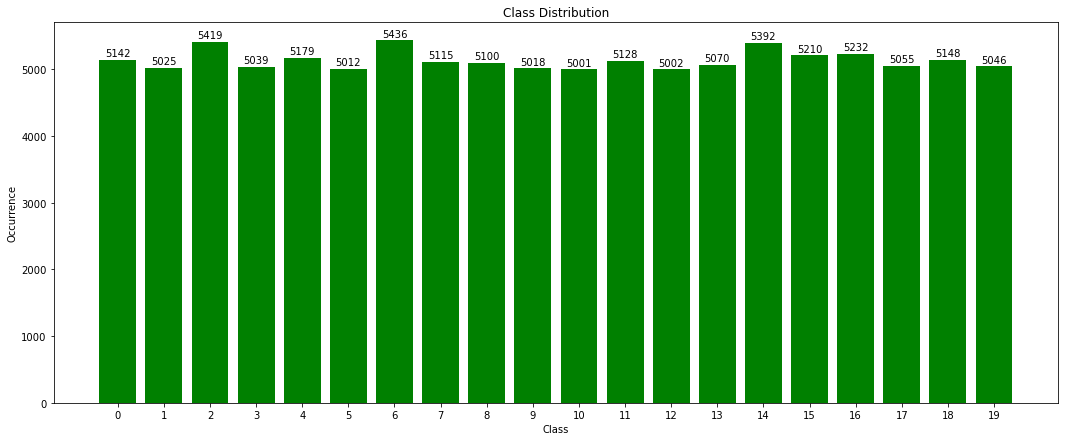

In [ ]:
merge_train_file = open("balanced_data_with_original.txt","r")

label_class_list = balanced_label(merge_train_file)

plt.figure(figsize=(18,7))
A = plt.bar(list(zip(*label_class_list))[0],list(zip(*label_class_list))[1], color = 'green')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Occurrence')
createBarLabels(A)

## 2. After Augmentation: Augmented Results

### Assign required path

In [ ]:
path = '/home/ingmember03/DL2020/DL2020_07/'
train_path = 'VOCdevkit_train After Augmentation/Balanced Data/'
test_path = 'VOCdevkit_test/VOC2007/JPEGImages/'
train_augmentation_path = 'VOCdevkit_train After Augmentation/Balanced Data with Augmentation/'
train_txt = 'balanced_data_with_original.txt'
test_txt = 'test_prediction_resnet152_balance.txt'
train_augmentation_txt = 'balanced_data_with_original_and_augmentation.txt'

### Define a class to record the image name, bounding box, and class from the dataset.

In [ ]:
class Image_Augmentation:

    def __init__(self, num_of_image ,txt):

        self.txt = txt
        self.num_of_image = num_of_image
        
        txt_content = open(path+ self.txt,'r')

        image_name = []
        for idx, line in enumerate(txt_content):
            line_adj = line.strip().split()
            image_name.append(line_adj[0])

        self.image_name = image_name

    def find_bounding_box_and_class(self):
        
        bounding_box_label = open(path + self.txt,'r')

        for idx, line in enumerate(bounding_box_label):
            line_adj = line.strip().split()
            if line_adj[0] == self.image_name[self.num_of_image]:
                bounding_box_and_class = line_adj[1:]
                break

        bounding_box = []
        class_ = []

        for idx, element in enumerate(bounding_box_and_class):
            if(idx%5==4):
                class_.append(element)
            else:
                bounding_box.append(element)     

        return((bounding_box, class_))

### Below output the balanced original images and corresponding bounding boxes with classes shown

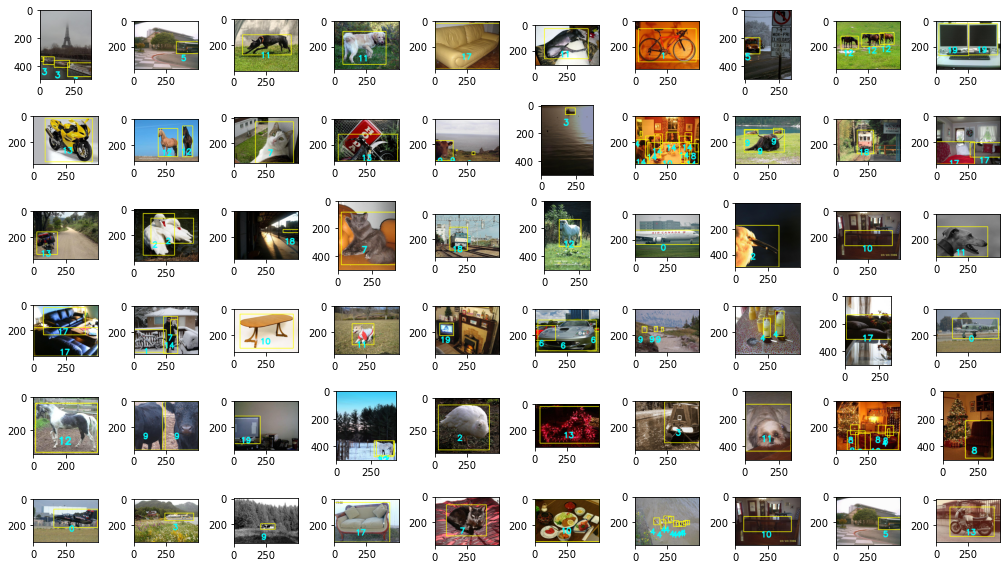

In [ ]:
col = 10
row = 6

fig, axs = plt.subplots(row, col,figsize = (14,8))
fig.tight_layout(pad=0.5)
count = 0

data_path = train_path
data_txt = train_txt
start_img = 0
end_image = 60630

random_image = list(map(math.floor,np.random.uniform(start_img,end_image,col*row)))

for img in random_image:
    
    bounding_box, class_ = Image_Augmentation(img, data_txt).find_bounding_box_and_class()
    np_img = cv2.imread(path + data_path + Image_Augmentation(0,data_txt).image_name[img])
    np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)


    if data_path == test_path:
        bounding_box = bounding_box[0:4]

    start = 0
    for i in range(len(bounding_box)):
        if(i%4 == 0):
            cv2.rectangle(np_img, (int(float(bounding_box[i])), int(float(bounding_box[i+1]))), (int(float(bounding_box[i+2])), int(float(bounding_box[i+3]))), (255, 255, 0), 3)
            # image, text, coordinate, font, size, color, line_width, line_type
            cv2.putText(np_img, class_[i//4], ((int(float(bounding_box[i]))+int(float(bounding_box[i+2])))//2-50,(int(float(bounding_box[i+1]))+int(float(bounding_box[i+3])))//2+100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 255), 8, cv2.LINE_AA)

    axs[count//col,count%col].imshow(np_img)

    count += 1
    if count == col*row:
        break

### Below output the augmented images and corresponding bounding boxes with classes shown (And these will be the input of the model)

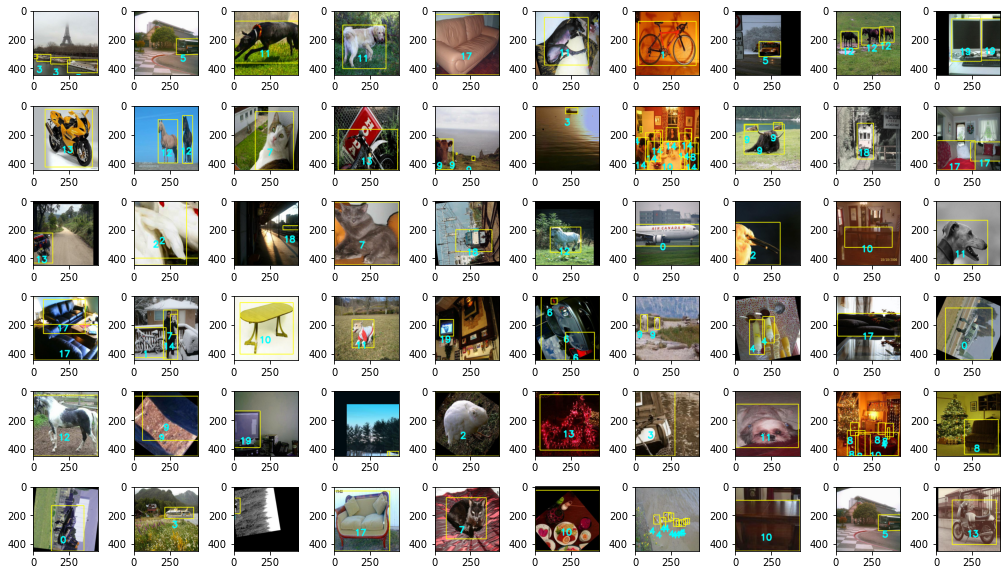

In [ ]:
fig, axs = plt.subplots(row, col,figsize = (14, 8))
fig.tight_layout(pad=0.5)
count = 0

data_path = train_augmentation_path
data_txt = train_augmentation_txt
start_img = 0
end_image = 60630

for img in random_image:
    
    bounding_box, class_ = Image_Augmentation(img, data_txt).find_bounding_box_and_class()
    np_img = cv2.imread(path + data_path + Image_Augmentation(0,data_txt).image_name[img])
    np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)

    if data_path == test_path:
        bounding_box = bounding_box[0:4]

    start = 0
    for i in range(len(bounding_box)):
        if(i%4 == 0):
            cv2.rectangle(np_img, (int(float(bounding_box[i])), int(float(bounding_box[i+1]))), (int(float(bounding_box[i+2])), int(float(bounding_box[i+3]))), (255, 255, 0), 3)
            # image, text, coordinate, font, size, color, line_width, line_type
            cv2.putText(np_img, class_[i//4], ((int(float(bounding_box[i]))+int(float(bounding_box[i+2])))//2-50,(int(float(bounding_box[i+1]))+int(float(bounding_box[i+3])))//2+100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 255), 8, cv2.LINE_AA)

    axs[count//col,count%col].imshow(np_img)

    count += 1
    if count == col*row:
        break


## 3. During Augmentation: Augmented Methods 

### ***Below are the 11 augmented methods that we had applied:***
### *A. to generalize the situation of the scene that images are taken*
#### 1. adjust_brightness
#### 2. adjust_contrast
#### 3. adjust_hue
#### 4. adjust saturation
#### 5. add_noise
#### 6. adjust_gamma

### *B. to generalize the location of the objects in the images are placed*
#### 1. shift
#### 2. central_zoom
#### 3. flip_up_down
#### 4. flip_left_right
#### 5. rotation


### Here, we Define 2 classes:
#### 1. Resize_Image: This class could help us to resize the image and the corresponding bounding box.
#### 2. Data_Augmentation: We can extract above 11 augmented methods from this class and apply to all the images that we would like to conduct augmentation.

In [ ]:
IMAGE_SIZE = 448

def Resize_Image(img_num):

    image_jpg = Image_Augmentation(img_num,train_txt).image_name[img_num]

    image_file = tf.io.read_file(path + train_path + image_jpg)
    image = tf.io.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    # print(tf.shape(image)[1])

    width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
    height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

    # print(width_ratio, height_ratio)

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) 

    bounding_box, class_ =  Image_Augmentation(img_num,train_txt).find_bounding_box_and_class()

    adj_bounding_box = []
    for i in range(len(bounding_box)):
        if i%2 == 0:
            adj_bounding_box.append((int(bounding_box[i]) * width_ratio).numpy())
        else:
            adj_bounding_box.append((int(bounding_box[i]) * height_ratio).numpy())

    return image_jpg, image, adj_bounding_box, class_

class Data_Augmentation:

    def __init__(self, image, adj_bounding_box, class_):

        self.image = image
        self.adj_bounding_box = adj_bounding_box
        self.class_ = class_

    def remain(self):

        bounding_box_adj = self.adj_bounding_box
        image_adj = np.array(self.image)

        return image_adj, bounding_box_adj, self.class_

    def flip_left_right(self):

        adj_bounding_box_horizontal_flip = []
        for i in range(len(self.adj_bounding_box)):
            if i%2 == 0:
                adj_bounding_box_horizontal_flip.append(IMAGE_SIZE - self.adj_bounding_box[i])
            else:
                adj_bounding_box_horizontal_flip.append(self.adj_bounding_box[i])

        for i in range(0,len(adj_bounding_box_horizontal_flip),4):
            if(i%4 == 0):
                temp = adj_bounding_box_horizontal_flip[i]
                adj_bounding_box_horizontal_flip[i] = adj_bounding_box_horizontal_flip[i+2]
                adj_bounding_box_horizontal_flip[i+2] = temp

        bounding_box_adj = adj_bounding_box_horizontal_flip
        image_adj = np.array(tf.image.flip_left_right(self.image))

        return image_adj, bounding_box_adj, self.class_

    def flip_up_down(self):

        adj_bounding_box_vertical_flip = []
        for i in range(len(self.adj_bounding_box)):
            if i%2 != 0:
                adj_bounding_box_vertical_flip.append(IMAGE_SIZE - self.adj_bounding_box[i])
            else:
                adj_bounding_box_vertical_flip.append(self.adj_bounding_box[i])

        for i in range(0,len(adj_bounding_box_vertical_flip),4):
            if(i%4 == 0):
                temp = adj_bounding_box_vertical_flip[i+1]
                adj_bounding_box_vertical_flip[i+1] = adj_bounding_box_vertical_flip[i+3]
                adj_bounding_box_vertical_flip[i+3] = temp

        bounding_box_adj = adj_bounding_box_vertical_flip
        image_adj = np.array(tf.image.flip_up_down(self.image))

        return image_adj, bounding_box_adj, self.class_

    def adjust_brightness(self):

        image_adj = tf.image.adjust_brightness(self.image, delta = np.random.uniform(-0.35,0.35,1))

        bounding_box_adj = self.adj_bounding_box
        image_adj = np.array(image_adj)

        return image_adj, bounding_box_adj, self.class_

    def adjust_contrast(self):
        
        image_adj = tf.image.random_contrast(self.image, lower = 0.2 , upper = 2, seed=None) # (x-mean) * contrast_factor + mean

        bounding_box_adj = self.adj_bounding_box
        image_adj = np.array(image_adj)

        return image_adj, bounding_box_adj, self.class_

    def adjust_gamma(self):

        image_adj = tf.image.adjust_gamma(self.image, gamma = tf.random.uniform(shape = (1,), minval = 1, maxval = 2, dtype=tf.float32), gain = tf.random.uniform(shape = (1,), minval = 1, maxval = 3, dtype=tf.float32))

        bounding_box_adj = self.adj_bounding_box
        image_adj = np.array(image_adj)

        return image_adj, bounding_box_adj, self.class_

    def add_noise(self):

        noise = tf.random.normal(shape=tf.shape(self.image.shape), mean=0, stddev=0.001, dtype=tf.float32)
        image_adj = tf.add(self.image, noise)

        bounding_box_adj = self.adj_bounding_box
        image_adj = np.array(image_adj)

        return image_adj, bounding_box_adj, self.class_

    def shift(self):

        stop = 0

        while stop == 0:

            pad_top = int(np.random.uniform(0,150,1)); pad_left = int(np.random.uniform(0,150,1)) ; pad_right = int(np.random.uniform(0,150,1)); pad_bottom = int(np.random.uniform(0,150,1))
            height = IMAGE_SIZE; width = IMAGE_SIZE

            Translation = tf.image.pad_to_bounding_box(self.image, pad_top, pad_left, height + pad_top + pad_bottom, width + pad_left + pad_right)
            image_adj = tf.image.crop_to_bounding_box(Translation, pad_bottom, pad_right, height, width)

            adj_bounding_box_Translation = []
            for i in range(len(self.adj_bounding_box)):
                if i%2 == 0:
                    adj_bounding_box_Translation.append(self.adj_bounding_box[i]+pad_left-pad_right)
                else:
                    adj_bounding_box_Translation.append(self.adj_bounding_box[i]+pad_top-pad_bottom)
                if adj_bounding_box_Translation[i] > 448:
                    adj_bounding_box_Translation[i] = 448
                if adj_bounding_box_Translation[i] < 0:
                    adj_bounding_box_Translation[i] = 0

            adj_bounding_box_Translation_remove_useless_box = []
            remove_class = []
            
            for i in range(len(adj_bounding_box_Translation)):
                if(i%4 == 0):
                    if (adj_bounding_box_Translation[i] != adj_bounding_box_Translation[i+2]) and (adj_bounding_box_Translation[i+1] != adj_bounding_box_Translation[i+3]):
                        for item in adj_bounding_box_Translation[i:i+4]:
                            adj_bounding_box_Translation_remove_useless_box.append(item)
                    else:
                        remove_class.append(i//4)

            bounding_box_adj = adj_bounding_box_Translation_remove_useless_box
            class_remove_useless_class = self.class_.copy()

            class_remove_useless_class = [item for idx, item in enumerate(class_remove_useless_class) if idx not in remove_class]
            image_adj = np.array(image_adj)

            if len(bounding_box_adj) > 0:
                stop = 1

        return image_adj, bounding_box_adj, class_remove_useless_class

    def central_zoom(self):
        
        stop = 0
    
        while stop < 5:

            central_fraction = np.round(np.random.uniform(0.3,0.949,1),1)[0]
            central_image = tf.image.central_crop(
                self.image, central_fraction
            )

            image_adj = tf.image.resize(central_image, size=[IMAGE_SIZE, IMAGE_SIZE])

            x_lower_bound = (IMAGE_SIZE-central_fraction*IMAGE_SIZE)/2
            x_upper_bound = (IMAGE_SIZE-central_fraction*IMAGE_SIZE)/2 + central_fraction*IMAGE_SIZE
            # square matrix
            y_lower_bound = x_lower_bound
            y_upper_bound = x_upper_bound

            adj_bounding_box_CenCrop = []
            remove_class = []

        # at least one vertex in the central image (xmin,ymin), (xmax,ymin), (xmin,ymax), (xmax,ymax) and the mid points (total 8 points needed to be included into the central image)
            for i in range(len(self.adj_bounding_box)):
                if i%4 == 0:
                    if ((self.adj_bounding_box[i] > x_lower_bound and self.adj_bounding_box[i] < x_upper_bound and self.adj_bounding_box[i+1] > y_lower_bound and self.adj_bounding_box[i+1] < y_upper_bound) or 
                    (self.adj_bounding_box[i] > x_lower_bound and self.adj_bounding_box[i] < x_upper_bound and self.adj_bounding_box[i+3] > y_lower_bound and self.adj_bounding_box[i+3] < y_upper_bound) or 
                    (self.adj_bounding_box[i+2] > x_lower_bound and self.adj_bounding_box[i+2] < x_upper_bound and self.adj_bounding_box[i+1] > y_lower_bound and self.adj_bounding_box[i+1] < y_upper_bound) or
                    (self.adj_bounding_box[i+2] > x_lower_bound and self.adj_bounding_box[i+2] < x_upper_bound and self.adj_bounding_box[i+3] > y_lower_bound and self.adj_bounding_box[i+3] < y_upper_bound) or
                    (round((self.adj_bounding_box[i]+self.adj_bounding_box[i+2])/2,2) > x_lower_bound and round((self.adj_bounding_box[i]+self.adj_bounding_box[i+2])/2,2) < x_upper_bound and self.adj_bounding_box[i+1] > y_lower_bound and self.adj_bounding_box[i+1] < y_upper_bound) or
                    (round((self.adj_bounding_box[i]+self.adj_bounding_box[i+2])/2,2) > x_lower_bound and round((self.adj_bounding_box[i]+self.adj_bounding_box[i+2])/2,2) < x_upper_bound and self.adj_bounding_box[i+3] > y_lower_bound and self.adj_bounding_box[i+3] < y_upper_bound) or        
                    (round((self.adj_bounding_box[i+1]+self.adj_bounding_box[i+3])/2,2) > y_lower_bound and round((self.adj_bounding_box[i+1]+self.adj_bounding_box[i+3])/2,2) < y_upper_bound and self.adj_bounding_box[i+0] > x_lower_bound and self.adj_bounding_box[i+0] < x_upper_bound) or
                    (round((self.adj_bounding_box[i+1]+self.adj_bounding_box[i+3])/2,2) > y_lower_bound and round((self.adj_bounding_box[i+1]+self.adj_bounding_box[i+3])/2,2) < y_upper_bound and self.adj_bounding_box[i+2] > x_lower_bound and self.adj_bounding_box[i+2] < x_upper_bound)):
                        adj_bounding_box_CenCrop += self.adj_bounding_box[i:i+4]
                    else:
                        remove_class.append(i//4)

            adj_bounding_box_CenCrop_adjust_margin = adj_bounding_box_CenCrop.copy()

            for i in range(len(adj_bounding_box_CenCrop)):
                if(i%4 == 0):
                    if adj_bounding_box_CenCrop[i] < x_lower_bound:
                        adj_bounding_box_CenCrop_adjust_margin[i] = x_lower_bound
                    if adj_bounding_box_CenCrop[i+1] < y_lower_bound:
                        adj_bounding_box_CenCrop_adjust_margin[i+1] = y_lower_bound
                    if adj_bounding_box_CenCrop[i+2] > x_upper_bound:
                        adj_bounding_box_CenCrop_adjust_margin[i+2] = x_upper_bound
                    if adj_bounding_box_CenCrop[i+3] > y_upper_bound:
                        adj_bounding_box_CenCrop_adjust_margin[i+3] = y_upper_bound

            adj_bounding_box_CenCrop_adjust_margin_to_origin = []
            for i in range(len(adj_bounding_box_CenCrop_adjust_margin)):
                adj_bounding_box_CenCrop_adjust_margin_to_origin.append(adj_bounding_box_CenCrop_adjust_margin[i] -  x_lower_bound) # y_lower_bound = x_lower_bound

            adj_bounding_box_CenCrop_adjust_margin_resize = []
            for i in range(len(adj_bounding_box_CenCrop_adjust_margin_to_origin)):
                if i%2 == 0:
                    adj_bounding_box_CenCrop_adjust_margin_resize.append(adj_bounding_box_CenCrop_adjust_margin_to_origin[i] * 1/central_fraction)
                else:
                    adj_bounding_box_CenCrop_adjust_margin_resize.append(adj_bounding_box_CenCrop_adjust_margin_to_origin[i] * 1/central_fraction)

            bounding_box_adj = adj_bounding_box_CenCrop_adjust_margin_resize.copy()
            image_adj = np.array(image_adj)

            class_remove_useless_class = self.class_.copy()
            class_remove_useless_class = [item for idx, item in enumerate(class_remove_useless_class) if idx not in remove_class]    

            # 5 chances, if still no object detected(no bounding box), then assign [0,0,448,448]
            if len(bounding_box_adj) == 0:
                stop += 1
            else:
                break

        # e.g. 6506 has too big inital bounding box
        if len(bounding_box_adj) == 0:
            bounding_box_adj = [0,0,448,448]
            class_remove_useless_class = self.class_.copy()

        return image_adj, bounding_box_adj, class_remove_useless_class

    def adjust_hue(self):

        image_adj = tf.image.random_hue(self.image, max_delta=0.1, seed=None)

        bounding_box_adj = self.adj_bounding_box
        image_adj = np.array(image_adj)

        return image_adj, bounding_box_adj, self.class_

    def adjust_saturation(self):

        image_adj = tf.image.random_saturation(self.image, lower = 0.2, upper=2, seed=None)

        bounding_box_adj = self.adj_bounding_box
        image_adj = np.array(image_adj)

        return image_adj, bounding_box_adj, self.class_

    def rotation(self):
        
        PIL_image = tf.keras.preprocessing.image.array_to_img(self.image, data_format=None, scale=True, dtype=None) # scale = True: within[0, 255] / return a PIL Image instance

        degree = np.random.uniform(-180,180,1)
        image_adj = PIL_image.rotate(-degree)

        IMAGE_CENTER = IMAGE_SIZE / 2

        # rotate bounding box with the image
        def new_vertex(x, y, x0, y0):

            x2 = x0+(x-x0)*math.cos(math.pi*degree/180)-(y-y0)*math.sin(math.pi*degree/180)
            y2 = y0+(x-x0)*math.sin(math.pi*degree/180)+(y-y0)*math.cos(math.pi*degree/180)

            return x2,y2

        adj_bounding_box_image_rotate_coordinate = []
        for i in range(len(self.adj_bounding_box)):
            if(i%4==0):
                adj_bounding_box_image_rotate_coordinate.append([
                new_vertex(self.adj_bounding_box[i],self.adj_bounding_box[i+1],IMAGE_CENTER,IMAGE_CENTER),
                new_vertex(self.adj_bounding_box[i],self.adj_bounding_box[i+3],IMAGE_CENTER,IMAGE_CENTER),
                new_vertex(self.adj_bounding_box[i+2],self.adj_bounding_box[i+1],IMAGE_CENTER,IMAGE_CENTER),
                new_vertex(self.adj_bounding_box[i+2],self.adj_bounding_box[i+3],IMAGE_CENTER,IMAGE_CENTER)])

        # find the center of each bounding box
        def find_coordinate_center(old_coordinate):
            
            max_x = []; min_x = []; max_y = []; min_y = []
            for i in range(len(old_coordinate)):
                x = []; y = []
                for j in range(len(old_coordinate[i])):
                    x.append([x for idx, x in enumerate(old_coordinate[i][j]) if idx == 0])
                    y.append([y for idx, y in enumerate(old_coordinate[i][j]) if idx == 1])
                max_x.append(max(x))
                min_x.append(min(x))
                max_y.append(max(y))
                min_y.append(min(y))

            return (min_x,min_y,max_x,max_y)

        ext_value = find_coordinate_center(adj_bounding_box_image_rotate_coordinate)

        adj_bounding_box_final = np.reshape(list(zip(*np.reshape(ext_value,(4,len(adj_bounding_box_image_rotate_coordinate))))),(-1))

        for i in range(len(adj_bounding_box_final)):
            if adj_bounding_box_final[i] > IMAGE_SIZE:
                adj_bounding_box_final[i] = IMAGE_SIZE
            if adj_bounding_box_final[i] < 0:
                adj_bounding_box_final[i] = 0

        bounding_box_adj = adj_bounding_box_final
        image_adj = np.array(image_adj)

        return image_adj, bounding_box_adj, self.class_


### Let's demonstrate the power of our data_augmentation, here, we provide two samples:

#### 1. Only apply shift to a specific image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


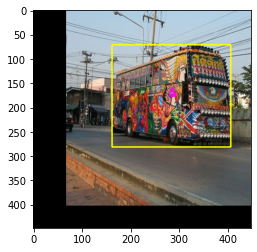

In [ ]:
img_num = 23307

image_name_output = Resize_Image(img_num)[0]
image_output, bounding_box_output, class_output = Data_Augmentation(Resize_Image(img_num)[1],Resize_Image(img_num)[2],Resize_Image(img_num)[3]).shift()[0:3]

for i in range(len(bounding_box_output)):
    if(i%4 == 0):
        cv2.rectangle(image_output, (int(bounding_box_output[i]), int(bounding_box_output[i+1])), (int(bounding_box_output[i+2]), int(bounding_box_output[i+3])), (255, 255, 0), 2)
        # image, text, coordinate, font, size, color, line_width, line_type
        cv2.putText(image_output, class_output[i//4], ((int(bounding_box_output[i])+int(bounding_box_output[i+2]))//2-5, (int(bounding_box_output[i+1])+int(bounding_box_output[i+3]))//2+1), cv2.FONT_HERSHEY_TRIPLEX, 0.7, (255, 0, 255), 2, cv2.LINE_AA)

plt.imshow(image_output)

#### 2. Apply central zoom, adjust gamma, and rotation at the same time to another specific image. 

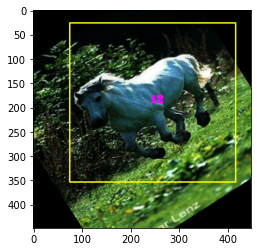

In [ ]:
start_img_num = 15000
img_num =  start_img_num

# restriction: can't rotation and then add_noise
np.random.uniform(0,10,1)
image_name_output = Resize_Image(img_num)[0]
image_output, bounding_box_output, class_output = Data_Augmentation(Resize_Image(img_num)[1],Resize_Image(img_num)[2],Resize_Image(img_num)[3]).central_zoom()[0:3]
image_output,bounding_box_output,class_output = Data_Augmentation(image_output,bounding_box_output,class_output).adjust_gamma()[0:3]
image_output,bounding_box_output,class_output = Data_Augmentation(image_output,bounding_box_output,class_output).rotation()[0:3]

for i in range(len(bounding_box_output)):
    if(i%4 == 0):
        cv2.rectangle(image_output, (int(bounding_box_output[i]), int(bounding_box_output[i+1])), (int(bounding_box_output[i+2]), int(bounding_box_output[i+3])), (255, 255, 0), 2)
        # image, text, coordinate, font, size, color, line_width, line_type
        cv2.putText(image_output, class_output[i//4], ((int(bounding_box_output[i])+int(bounding_box_output[i+2]))//2-5, (int(bounding_box_output[i+1])+int(bounding_box_output[i+3]))//2+1), cv2.FONT_HERSHEY_TRIPLEX, 0.7, (255, 0, 255), 2, cv2.LINE_AA)

plt.imshow(image_output)

### - As demonstrated in above examples, it seems like the data augmentation class looks great, thus, we can output the augmented images.
### - We remain the original 4974 images and augment 55000+ additional images.

### ***(Without augmentation) Output Original 4974 Images - time consuming***

In [ ]:
# end_img_num = 4974

# training_txt_after_augmentation = []

# for img_num in range(0,end_img_num,1):

#     image_name_output = Resize_Image(img_num)[0]
#     image_output, bounding_box_output, class_output = Data_Augmentation(Resize_Image(img_num)[1],Resize_Image(img_num)[2],Resize_Image(img_num)[3]).remain()[0:3]

#     PIL_image = tf.keras.preprocessing.image.array_to_img(
#         image_output, data_format=None, scale=True, dtype=None # scale = True: within[0, 255]
#     ) 

#     PIL_image.save("./VOCdevkit_train After Augmentation/Balanced Data with Augmentation ver2/" + image_name_output) 

#     training_txt_after_augmentation_line = []

#     training_txt_after_augmentation_line.append(image_name_output)

#     classi = 0

#     for i in range(len(bounding_box_output)):
#         training_txt_after_augmentation_line.append(bounding_box_output[i])
#         if (i+1)%4 == 0 and i !=0 :
#             training_txt_after_augmentation_line.append(int(class_output[classi]))
#             classi += 1

#     additional_train_file = open("balanced_data_with_original_and_augmentation_ver2.txt","a") 
#     additional_train_file.write(str(' '.join(map(str,training_txt_after_augmentation_line)))+'\n')
#     additional_train_file.close()
#     # training_txt_after_augmentation.append(' '.join(map(str,training_txt_after_augmentation_line)))

#     # if (img_num)%500 == 0:
#     #     print(img_num)

### ***(With augmentation) Output randomly augmented 55000+ Images - time consuming***

In [ ]:
# start_img_num = 4974+6457
# used = []
# for img_num in list(map(math.floor,np.random.uniform(start_img_num,len(Image_Augmentation(img_num,train_txt).image_name),20000))):

#     if img_num not in used:
#         stop = 0

#         while stop == 0:

#             chance1 = math.floor(np.random.uniform(1,8,1))
#             chance2 = math.floor(np.random.uniform(1,7,1))
#             chance3 = math.floor(np.random.uniform(1,4,1))

#             image_name_output = Resize_Image(img_num)[0]
#             image_output = Resize_Image(img_num)[1].numpy()
#             bounding_box_output = Resize_Image(img_num)[2]
#             class_output = Resize_Image(img_num)[3]

#             if chance1 == 1:
#                 image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).adjust_brightness()[0:3]
#             elif chance1 == 2:
#                 image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).adjust_contrast()[0:3]
#             elif chance1 == 3:
#                 image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).adjust_saturation()[0:3]
#             elif chance1 == 4:
#                 image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).adjust_hue()[0:3]
#             elif chance1 == 5:
#                 image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).adjust_gamma()[0:3]
#             # elif chance1 == 6 or chance1 == 10:
#             #     image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).shift()[0:3]
#             elif chance1 == 6:
#                 image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).remain()[0:3]
#             elif chance1 == 7:
#                 image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).add_noise()[0:3]
#             # elif chance1 == 9 or chance1 == 11 or chance1 == 12:
#             #     image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).central_zoom()[0:3]

#             if chance2 == 1:
#                 image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).adjust_brightness()[0:3]
#             elif chance2 == 2:
#                 image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).adjust_contrast()[0:3]
#             elif chance2 == 3:
#                 image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).adjust_saturation()[0:3]
#             elif chance2 == 4:
#                 image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).adjust_hue()[0:3]
#             elif chance2 == 5:
#                 image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).add_noise()[0:3]
#             elif chance2 == 6:
#                 image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).remain()[0:3]

#             if np.random.uniform(1,4,1)/3 <= 2/3:
#                 # if chance3 == 1:
#                     # image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).rotation()[0:3]
#                 if chance3 == 1:
#                     image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).flip_left_right()[0:3]
#                 elif chance3 == 2:
#                     image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).flip_up_down()[0:3]
#                 elif chance3 == 3:
#                     image_output, bounding_box_output, class_output = Data_Augmentation(image_output,bounding_box_output,class_output).remain()[0:3]

#             if sum(sum(sum(image_output))) != 0:
#                 stop = 1

#         PIL_image = tf.keras.preprocessing.image.array_to_img(
#             image_output, data_format=None, scale=True, dtype=None # scale = True: within[0, 255]
#         ) 

#         PIL_image.save("./VOCdevkit_train After Augmentation/Balanced Data with Augmentation ver2/" + image_name_output) 

#         training_txt_after_augmentation_line = []

#         training_txt_after_augmentation_line.append(image_name_output)

#         classi = 0
    
#         for i in range(len(bounding_box_output)):
#             training_txt_after_augmentation_line.append(bounding_box_output[i])
#             if (i+1)%4 == 0 and i !=0 :
#                 training_txt_after_augmentation_line.append(int(class_output[classi]))
#                 classi += 1

#         additional_train_file = open("balanced_data_with_original_and_augmentation_ver2.txt","a") 
#         additional_train_file.write(str(' '.join(map(str,training_txt_after_augmentation_line)))+'\n')
#         additional_train_file.close()
#         # training_txt_after_augmentation.append(' '.join(map(str,training_txt_after_augmentation_line)))
#         # if (img_num-4974)%500 == 0:
#         #     print(img_num)

#     used.append(img_num)


### Now, let's dive into the class data_augmentation and see how each augmented functions works.

### **First of all, let's initialize an image, and its corresponding bounding box and class**

### ***Resize Image: The original but resized image is output as below***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


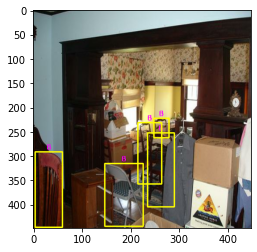

In [ ]:
img_num = 0

def Resize_Image(img_num):
    IMAGE_SIZE = 448

    image_jpg = Image_Augmentation(img_num,train_txt).image_name[img_num]

    image_file = tf.io.read_file(path + train_path + image_jpg)
    image = tf.io.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    # print(tf.shape(image)[1])

    width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
    height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

    # print(width_ratio, height_ratio)

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) 

    bounding_box, class_ =  Image_Augmentation(img_num,train_txt).find_bounding_box_and_class()

    adj_bounding_box = []
    for i in range(len(bounding_box)):
        if i%2 == 0:
            adj_bounding_box.append((int(bounding_box[i]) * width_ratio).numpy())
        else:
            adj_bounding_box.append((int(bounding_box[i]) * height_ratio).numpy())

    return image, adj_bounding_box, class_

image, adj_bounding_box, class_ = Resize_Image(img_num)

image_adj = np.array(image)
for i in range(len(adj_bounding_box)):
    if(i%4 == 0):
        cv2.rectangle(image_adj, (int(adj_bounding_box[i]), int(adj_bounding_box[i+1])), (int(adj_bounding_box[i+2]), int(adj_bounding_box[i+3])), (255, 255, 0), 2)
        # image, text, coordinate, font, size, color, line_width, line_type
        cv2.putText(image_adj, class_[i//4], ((int(adj_bounding_box[i])+int(adj_bounding_box[i+2]))//2-5, int(adj_bounding_box[i+1])-5), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 255), 1, cv2.LINE_AA)

plt.imshow(image_adj)
plt.show()

### ***Now, let's break down the class data_augmentation.*** (Below we'll exhibit the 11 methods / functions in class respectively.)

### ***Flip Left and Right***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


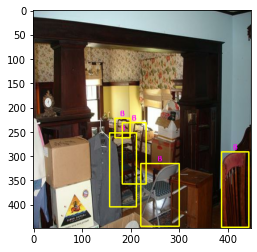

In [ ]:
adj_bounding_box_horizontal_flip = []
for i in range(len(adj_bounding_box)):
    if i%2 == 0:
        adj_bounding_box_horizontal_flip.append(IMAGE_SIZE - adj_bounding_box[i])
    else:
        adj_bounding_box_horizontal_flip.append(adj_bounding_box[i])

for i in range(0,len(adj_bounding_box_horizontal_flip),4):
    if(i%4 == 0):
        temp = adj_bounding_box_horizontal_flip[i]
        adj_bounding_box_horizontal_flip[i] = adj_bounding_box_horizontal_flip[i+2]
        adj_bounding_box_horizontal_flip[i+2] = temp

bounding_box_adj = adj_bounding_box_horizontal_flip
image_adj = np.array(tf.image.flip_left_right(image))

for i in range(len(adj_bounding_box)):
    if(i%4 == 0):
        cv2.rectangle(image_adj, (int(bounding_box_adj[i]), int(bounding_box_adj[i+1])), (int(bounding_box_adj[i+2]), int(bounding_box_adj[i+3])), (255, 255, 0), 2)
        # image, text, coordinate, font, size, color, line_width, line_type
        cv2.putText(image_adj, class_[i//4], ((int(bounding_box_adj[i])+int(bounding_box_adj[i+2]))//2-5, int(bounding_box_adj[i+1])-5), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 255), 1, cv2.LINE_AA)

plt.imshow(image_adj)
plt.show()


### ***Flip Up and Down***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


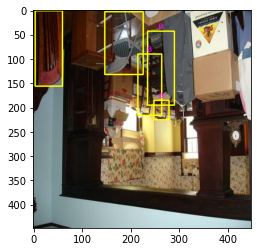

In [ ]:
adj_bounding_box_vertical_flip = []
for i in range(len(adj_bounding_box)):
    if i%2 != 0:
        adj_bounding_box_vertical_flip.append(IMAGE_SIZE - adj_bounding_box[i])
    else:
        adj_bounding_box_vertical_flip.append(adj_bounding_box[i])

for i in range(0,len(adj_bounding_box_vertical_flip),4):
    if(i%4 == 0):
        temp = adj_bounding_box_vertical_flip[i+1]
        adj_bounding_box_vertical_flip[i+1] = adj_bounding_box_vertical_flip[i+3]
        adj_bounding_box_vertical_flip[i+3] = temp

bounding_box_adj = adj_bounding_box_vertical_flip
image_adj = np.array(tf.image.flip_up_down(image))

for i in range(len(adj_bounding_box)):
    if(i%4 == 0):
        cv2.rectangle(image_adj, (int(bounding_box_adj[i]), int(bounding_box_adj[i+1])), (int(bounding_box_adj[i+2]), int(bounding_box_adj[i+3])), (255, 255, 0), 2)
        # image, text, coordinate, font, size, color, line_width, line_type
        cv2.putText(image_adj, class_[i//4], ((int(bounding_box_adj[i])+int(bounding_box_adj[i+2]))//2-5, int(bounding_box_adj[i+1])-5), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 255), 1, cv2.LINE_AA)

plt.imshow(image_adj)
plt.show()

### ***Adjust Brightness***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


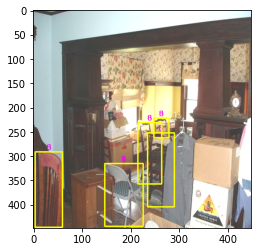

In [ ]:
image_adj = tf.image.adjust_brightness(
    image, delta = np.random.uniform(-0.35,0.35,1)  # add on original value (x + delta) delta range: between -1 and 1
)

bounding_box_adj = adj_bounding_box

image_adj = np.array(image_adj)

for i in range(len(adj_bounding_box)):
    if(i%4 == 0):
        cv2.rectangle(image_adj, (int(bounding_box_adj[i]), int(bounding_box_adj[i+1])), (int(bounding_box_adj[i+2]), int(bounding_box_adj[i+3])), (255, 255, 0), 2)
        # image, text, coordinate, font, size, color, line_width, line_type
        cv2.putText(image_adj, class_[i//4], ((int(bounding_box_adj[i])+int(bounding_box_adj[i+2]))//2-5, int(bounding_box_adj[i+1])-5), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 255), 1, cv2.LINE_AA)


plt.imshow(image_adj)
plt.show()

### ***Adjust Contrast***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


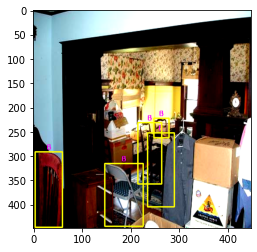

In [ ]:
image_adj = tf.image.random_contrast(
    image, lower = 0.3 , upper = 2, seed=None # (x-mean) * contrast_factor + mean
)

bounding_box_adj = adj_bounding_box

image_adj = np.array(image_adj)

for i in range(len(adj_bounding_box)):
    if(i%4 == 0):
        cv2.rectangle(image_adj, (int(bounding_box_adj[i]), int(bounding_box_adj[i+1])), (int(bounding_box_adj[i+2]), int(bounding_box_adj[i+3])), (255, 255, 0), 2)
        # image, text, coordinate, font, size, color, line_width, line_type
        cv2.putText(image_adj, class_[i//4], ((int(bounding_box_adj[i])+int(bounding_box_adj[i+2]))//2-5, int(bounding_box_adj[i+1])-5), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 255), 1, cv2.LINE_AA)


plt.imshow(image_adj)
plt.show()

### ***Adjust Gamma***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


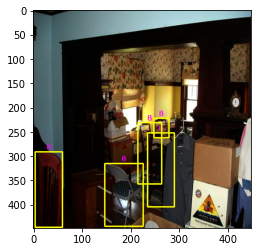

In [ ]:
image_adj = tf.image.adjust_gamma(
    image, gamma = tf.random.uniform(shape = (1,), minval = 1, maxval = 2, dtype=tf.float32), gain = tf.random.uniform(shape = (1,), minval = 1, maxval = 3, dtype=tf.float32)
)

bounding_box_adj = adj_bounding_box

image_adj = np.array(image_adj)

for i in range(len(adj_bounding_box)):
    if(i%4 == 0):
        cv2.rectangle(image_adj, (int(bounding_box_adj[i]), int(bounding_box_adj[i+1])), (int(bounding_box_adj[i+2]), int(bounding_box_adj[i+3])), (255, 255, 0), 2)
        # image, text, coordinate, font, size, color, line_width, line_type
        cv2.putText(image_adj, class_[i//4], ((int(bounding_box_adj[i])+int(bounding_box_adj[i+2]))//2-5, int(bounding_box_adj[i+1])-5), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 255), 1, cv2.LINE_AA)


plt.imshow(image_adj)
plt.show()

### ***Add Noise***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


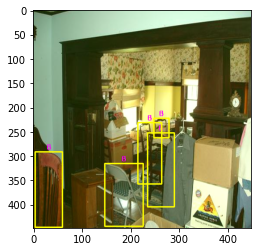

In [ ]:
noise = tf.random.normal(shape=tf.shape(image.shape), mean=0, stddev=0.05, dtype=tf.float32)
image_adj = tf.add(image, noise)

bounding_box_adj = adj_bounding_box

image_adj = np.array(image_adj)

for i in range(len(adj_bounding_box)):
    if(i%4 == 0):
        cv2.rectangle(image_adj, (int(bounding_box_adj[i]), int(bounding_box_adj[i+1])), (int(bounding_box_adj[i+2]), int(bounding_box_adj[i+3])), (255, 255, 0), 2)
        # image, text, coordinate, font, size, color, line_width, line_type
        cv2.putText(image_adj, class_[i//4], ((int(bounding_box_adj[i])+int(bounding_box_adj[i+2]))//2-5, int(bounding_box_adj[i+1])-5), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 255), 1, cv2.LINE_AA)


plt.imshow(image_adj)
plt.show()

### ***Shift***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


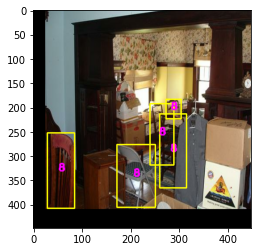

In [ ]:
pad_top = int(np.random.uniform(0,150,1)); pad_left = int(np.random.uniform(0,150,1)) ; pad_right = int(np.random.uniform(0,150,1)); pad_bottom = int(np.random.uniform(0,150,1))
height = IMAGE_SIZE; width = IMAGE_SIZE

Transaction = tf.image.pad_to_bounding_box(image, pad_top, pad_left, height + pad_top + pad_bottom, width + pad_left + pad_right)
image_adj = tf.image.crop_to_bounding_box(Transaction, pad_bottom, pad_right, height, width)

adj_bounding_box_Translation = []
for i in range(len(adj_bounding_box)):
    if i%2 == 0:
        adj_bounding_box_Translation.append(adj_bounding_box[i]+pad_left-pad_right)
    else:
        adj_bounding_box_Translation.append(adj_bounding_box[i]+pad_top-pad_bottom)
    if adj_bounding_box_Translation[i] > IMAGE_SIZE:
        adj_bounding_box_Translation[i] = IMAGE_SIZE
    if adj_bounding_box_Translation[i] < 0:
        adj_bounding_box_Translation[i] = 0

adj_bounding_box_Translation_remove_useless_box = []
remove_class = []
for i in range(len(adj_bounding_box_Translation)):
    if(i%4 == 0):
        if (adj_bounding_box_Translation[i] != adj_bounding_box_Translation[i+2]) and (adj_bounding_box_Translation[i+1] != adj_bounding_box_Translation[i+3]):
            for item in adj_bounding_box_Translation[i:i+4]:
                adj_bounding_box_Translation_remove_useless_box.append(item)
        else:
            remove_class.append(i//4)

bounding_box_adj = adj_bounding_box_Translation_remove_useless_box
class_remove_useless_class = class_.copy()

class_remove_useless_class = [item for idx, item in enumerate(class_remove_useless_class) if idx not in remove_class]

image_adj = np.array(image_adj)

for i in range(len(bounding_box_adj)):
    if(i%4 == 0):
        cv2.rectangle(image_adj, (int(bounding_box_adj[i]), int(bounding_box_adj[i+1])), (int(bounding_box_adj[i+2]), int(bounding_box_adj[i+3])), (255, 255, 0), 2)
        # image, text, coordinate, font, size, color, line_width, line_type
        cv2.putText(image_adj, class_remove_useless_class[i//4], ((int(bounding_box_adj[i])+int(bounding_box_adj[i+2]))//2-5, (int(bounding_box_adj[i+1])+int(bounding_box_adj[i+3]))//2+1), cv2.FONT_HERSHEY_TRIPLEX, 0.7, (255, 0, 255), 2, cv2.LINE_AA)


plt.imshow(image_adj)
plt.show()

### ***Central Zoom***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class left: ['8', '8', '8', '8']


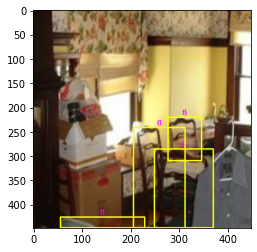

In [ ]:
central_fraction = np.random.uniform(0.2,1,1)[0]
central_image = tf.image.central_crop(
    image, central_fraction
)

image_adj = tf.image.resize(central_image, size=[IMAGE_SIZE, IMAGE_SIZE])

x_lower_bound = (IMAGE_SIZE-central_fraction*IMAGE_SIZE)/2
x_upper_bound = (IMAGE_SIZE-central_fraction*IMAGE_SIZE)/2 + central_fraction*IMAGE_SIZE
# square matrix
y_lower_bound = x_lower_bound
y_upper_bound = x_upper_bound

adj_bounding_box_CenCrop = []
remove_class = []

# at least one vertex in the central image (xmin,ymin), (xmax,ymin), (xmin,ymax), (xmax,ymax) and the mid points (total 8 points needed to be included into the central image)
for i in range(len(adj_bounding_box)):
    if i%4 == 0:
        if ((adj_bounding_box[i] > x_lower_bound and adj_bounding_box[i] < x_upper_bound and adj_bounding_box[i+1] > y_lower_bound and adj_bounding_box[i+1] < y_upper_bound) or 
        (adj_bounding_box[i] > x_lower_bound and adj_bounding_box[i] < x_upper_bound and adj_bounding_box[i+3] > y_lower_bound and adj_bounding_box[i+3] < y_upper_bound) or 
        (adj_bounding_box[i+2] > x_lower_bound and adj_bounding_box[i+2] < x_upper_bound and adj_bounding_box[i+1] > y_lower_bound and adj_bounding_box[i+1] < y_upper_bound) or
        (adj_bounding_box[i+2] > x_lower_bound and adj_bounding_box[i+2] < x_upper_bound and adj_bounding_box[i+3] > y_lower_bound and adj_bounding_box[i+3] < y_upper_bound) or
        ((adj_bounding_box[i]+adj_bounding_box[i+2])/2 > x_lower_bound and (adj_bounding_box[i]+adj_bounding_box[i+2])/2 < x_upper_bound and adj_bounding_box[i+1] > y_lower_bound and adj_bounding_box[i+1] < y_upper_bound) or
        ((adj_bounding_box[i]+adj_bounding_box[i+2])/2 > x_lower_bound and (adj_bounding_box[i]+adj_bounding_box[i+2])/2 < x_upper_bound and adj_bounding_box[i+3] > y_lower_bound and adj_bounding_box[i+3] < y_upper_bound) or        
        ((adj_bounding_box[i+1]+adj_bounding_box[i+3])/2 > y_lower_bound and (adj_bounding_box[i+1]+adj_bounding_box[i+3])/2 < y_upper_bound and adj_bounding_box[i+0] > x_lower_bound and adj_bounding_box[i+0] < x_upper_bound) or
        ((adj_bounding_box[i+1]+adj_bounding_box[i+3])/2 > y_lower_bound and (adj_bounding_box[i+1]+adj_bounding_box[i+3])/2 < y_upper_bound and adj_bounding_box[i+2] > x_lower_bound and adj_bounding_box[i+2] < x_upper_bound)):
            adj_bounding_box_CenCrop += adj_bounding_box[i:i+4]
        else:
            remove_class.append(i//4)

adj_bounding_box_CenCrop_adjust_margin = adj_bounding_box_CenCrop.copy()

for i in range(len(adj_bounding_box_CenCrop)):
    if(i%4 == 0):
        if adj_bounding_box_CenCrop[i] < x_lower_bound:
            adj_bounding_box_CenCrop_adjust_margin[i] = x_lower_bound
        if adj_bounding_box_CenCrop[i+1] < y_lower_bound:
            adj_bounding_box_CenCrop_adjust_margin[i+1] = y_lower_bound
        if adj_bounding_box_CenCrop[i+2] > x_upper_bound:
            adj_bounding_box_CenCrop_adjust_margin[i+2] = x_upper_bound
        if adj_bounding_box_CenCrop[i+3] > y_upper_bound:
            adj_bounding_box_CenCrop_adjust_margin[i+3] = y_upper_bound

adj_bounding_box_CenCrop_adjust_margin_to_origin = []
for i in range(len(adj_bounding_box_CenCrop_adjust_margin)):
    adj_bounding_box_CenCrop_adjust_margin_to_origin.append(adj_bounding_box_CenCrop_adjust_margin[i] -  x_lower_bound) # y_lower_bound = x_lowr_bound

adj_bounding_box_CenCrop_adjust_margin_resize = []
for i in range(len(adj_bounding_box_CenCrop_adjust_margin_to_origin)):
    if i%2 == 0:
        adj_bounding_box_CenCrop_adjust_margin_resize.append(adj_bounding_box_CenCrop_adjust_margin_to_origin[i] * 1/central_fraction)
    else:
        adj_bounding_box_CenCrop_adjust_margin_resize.append(adj_bounding_box_CenCrop_adjust_margin_to_origin[i] * 1/central_fraction)

bounding_box_adj = adj_bounding_box_CenCrop_adjust_margin_resize.copy()
class_remove_useless_class = class_.copy()

class_remove_useless_class = [item for idx, item in enumerate(class_remove_useless_class) if idx not in remove_class]

image_adj = np.array(image_adj)

for i in range(len(bounding_box_adj)):
    if(i%4 == 0):
        cv2.rectangle(image_adj, (int(bounding_box_adj[i]), int(bounding_box_adj[i+1])), (int(bounding_box_adj[i+2]), int(bounding_box_adj[i+3])), (255, 255, 0), 2)
        # image, text, coordinate, font, size, color, line_width, line_type
        cv2.putText(image_adj, class_remove_useless_class[i//4], ((int(bounding_box_adj[i])+int(bounding_box_adj[i+2]))//2-5, int(bounding_box_adj[i+1])-5), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 255), 1, cv2.LINE_AA)

print("Class left:", class_remove_useless_class)

plt.imshow(image_adj)
plt.show()

### ***Rotation***

[251.55634595 199.8961858  395.17167248 349.55602478 229.60701037
 289.55748152 374.91229792 437.94932913 107.778488   384.5495928
 253.66878012 448.         223.30213679 202.48112358 343.72790049
 327.64696214 240.62339534 185.14355387 291.18705609 236.27675852]


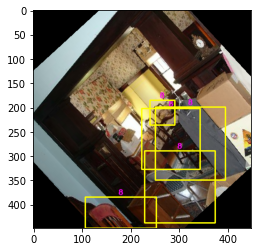

In [ ]:
PIL_image = tf.keras.preprocessing.image.array_to_img(
    image.numpy(), data_format=None, scale=True, dtype=None # scale = True: within[0, 255]
) # return a PIL Image instance

degree = np.random.uniform(-180,180,1)
image_adj = PIL_image.rotate(-degree)

IMAGE_CENTER = 224

# rotate bounding box with the image
def new_vertex(x, y, x0, y0):

    x2 = x0+(x-x0)*math.cos(math.pi*degree/180)-(y-y0)*math.sin(math.pi*degree/180)
    y2 = y0+(x-x0)*math.sin(math.pi*degree/180)+(y-y0)*math.cos(math.pi*degree/180)

    return x2,y2

adj_bounding_box_image_rotate_coordinate = []
for i in range(len(adj_bounding_box)):
    if(i%4==0):
        adj_bounding_box_image_rotate_coordinate.append([
        new_vertex(adj_bounding_box[i],adj_bounding_box[i+1],IMAGE_CENTER,IMAGE_CENTER),
        new_vertex(adj_bounding_box[i],adj_bounding_box[i+3],IMAGE_CENTER,IMAGE_CENTER),
        new_vertex(adj_bounding_box[i+2],adj_bounding_box[i+1],IMAGE_CENTER,IMAGE_CENTER),
        new_vertex(adj_bounding_box[i+2],adj_bounding_box[i+3],IMAGE_CENTER,IMAGE_CENTER)])

# find the center of each bounding box
def find_coordinate_center(old_coordinate):
    
    max_x = []; min_x = []; max_y = []; min_y = []
    for i in range(len(old_coordinate)):
        x = []; y = []
        for j in range(len(old_coordinate[i])):
            x.append([x for idx, x in enumerate(old_coordinate[i][j]) if idx == 0])
            y.append([y for idx, y in enumerate(old_coordinate[i][j]) if idx == 1])
        max_x.append(max(x))
        min_x.append(min(x))
        max_y.append(max(y))
        min_y.append(min(y))

    return (min_x,min_y,max_x,max_y)

ext_value = find_coordinate_center(adj_bounding_box_image_rotate_coordinate)

adj_bounding_box_final = np.reshape(list(zip(*np.reshape(ext_value,(4,len(adj_bounding_box_image_rotate_coordinate))))),(-1))

for i in range(len(adj_bounding_box_final)):
    if adj_bounding_box_final[i] > IMAGE_SIZE:
        adj_bounding_box_final[i] = IMAGE_SIZE
    if adj_bounding_box_final[i] < 0:
        adj_bounding_box_final[i] = 0

bounding_box_adj = adj_bounding_box_final
image_adj = np.array(image_adj)

print(bounding_box_adj)

for i in range(len(bounding_box_adj)):
    if(i%4 == 0):
        cv2.rectangle(image_adj, (int(bounding_box_adj[i]), int(bounding_box_adj[i+1])), (int(bounding_box_adj[i+2]), int(bounding_box_adj[i+3])), (255, 255, 0), 2)
        # image, text, coordinate, font, size, color, line_width, line_type
        cv2.putText(image_adj, class_[i//4], ((int(bounding_box_adj[i])+int(bounding_box_adj[i+2]))//2-5, int(bounding_box_adj[i+1])-5), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 255), 1, cv2.LINE_AA)

plt.imshow(image_adj)
plt.show()

### ***Adjust Hue***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


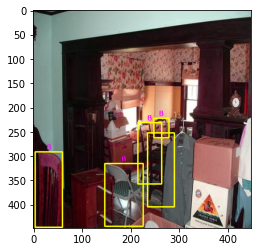

In [ ]:
image_adj = tf.image.random_hue(
    image, max_delta=0.1, seed=None
)

bounding_box_adj = adj_bounding_box
image_adj = np.array(image_adj)

for i in range(len(adj_bounding_box)):
    if(i%4 == 0):
        cv2.rectangle(image_adj, (int(bounding_box_adj[i]), int(bounding_box_adj[i+1])), (int(bounding_box_adj[i+2]), int(bounding_box_adj[i+3])), (255, 255, 0), 2)
        # image, text, coordinate, font, size, color, line_width, line_type
        cv2.putText(image_adj, class_[i//4], ((int(bounding_box_adj[i])+int(bounding_box_adj[i+2]))//2-5, int(bounding_box_adj[i+1])-5), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 255), 1, cv2.LINE_AA)


plt.imshow(image_adj)
plt.show()

### ***Adjust Saturation***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


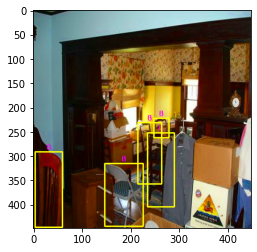

In [ ]:
image_adj = tf.image.random_saturation(
    image, lower = 0.2, upper=2, seed=None
)

bounding_box_adj = adj_bounding_box

image_adj = np.array(image_adj)

for i in range(len(adj_bounding_box)):
    if(i%4 == 0):
        cv2.rectangle(image_adj, (int(bounding_box_adj[i]), int(bounding_box_adj[i+1])), (int(bounding_box_adj[i+2]), int(bounding_box_adj[i+3])), (255, 255, 0), 2)
        # image, text, coordinate, font, size, color, line_width, line_type
        cv2.putText(image_adj, class_[i//4], ((int(bounding_box_adj[i])+int(bounding_box_adj[i+2]))//2-5, int(bounding_box_adj[i+1])-5), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 255), 1, cv2.LINE_AA)


plt.imshow(image_adj)
plt.show()

# ***2. Image Balancing / Augmentation through Tensorflow pipeline / data generator***

#### Image Balancing

這裡我們嘗試了不同的image balancing 的方法。由於person的label最多，因此我們在固定這個label的情況下，去手動增加其他label。最後調整出來的結果，最大與最小的label差大約為2倍，在可以接受的範圍。

In [ ]:
training_data_file = open("./pascal_voc_training_data.txt", "r")
train = []
new_count = []
for i, line in enumerate(training_data_file):
    line = line.strip()
    train.append(line)
    tmp = line.split()
    #print(tmp)
    count_tmp = np.zeros(len(classes_name))
    tmp_j = []
    for j in range(5, len(tmp), 5):
        tmp_j.append(tmp[j])
        
    for k in range(len(classes_name)):
        count_tmp[k] = tmp_j.count(str(k))

    new_count.append(count_tmp)

#%%
### index 5
for i in range(len(new_count)):
    if new_count[i][5] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 26):
            train.append(train[j])

### index 0
for i in range(len(new_count)):
    if new_count[i][0] > 0 and new_count[i][14] == 0 and new_count[i][6] == 0 and new_count[i][5] == 0 and new_count[i][8] == 0:
        for j in np.repeat(i, 10):
            train.append(train[j])


### index 1
for i in range(len(new_count)):
    if new_count[i][1] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 40):
            train.append(train[j])

### index 2
for i in range(len(new_count)):
    if new_count[i][2] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 6):
            train.append(train[j])

### index 3
for i in range(len(new_count)):
    if new_count[i][3] > 0 and new_count[i][14] == 0 and new_count[i][2] == 0:
        for j in np.repeat(i, 10):
            train.append(train[j])

### index 4
for i in range(len(new_count)):
    if new_count[i][4] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 6):
            train.append(train[j])

### index 7
for i in range(len(new_count)):
    if new_count[i][7] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 10):
            train.append(train[j])

### index 9
for i in range(len(new_count)):
    if new_count[i][9] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 15):
            train.append(train[j])

### index 10
for i in range(len(new_count)):
    if new_count[i][10] > 0 and new_count[i][14] < 2 and new_count[i][8] < 3:
        for j in np.repeat(i, 60):
            train.append(train[j])

### index 11
for i in range(len(new_count)):
    if new_count[i][11] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 10):
            train.append(train[j])

### index 12
for i in range(len(new_count)):
    if new_count[i][12] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 40):
            train.append(train[j])
            
### index 13
for i in range(len(new_count)):
    if new_count[i][13] > 0 and new_count[i][14] == 0 and new_count[i][6] == 0 and new_count[i][10] == 0:
        for j in np.repeat(i, 40):
            train.append(train[j])

### index 18
for i in range(len(new_count)):
    if new_count[i][18] > 0 and new_count[i][14] == 0 and new_count[i][6] == 0 and new_count[i][5] == 0 and new_count[i][8] == 0 and new_count[i][10] == 0:
        for j in np.repeat(i, 15):
            train.append(train[j])
            
### index 15
for i in range(len(new_count)):
    if new_count[i][15] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 3):
            train.append(train[j])
            
### index 16
for i in range(len(new_count)):
    if new_count[i][16] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 10):
            train.append(train[j])

### index 17
for i in range(len(new_count)):
    if new_count[i][17] > 0 and new_count[i][14] == 0 and new_count[i][8] == 0 and new_count[i][15] == 0:
        for j in np.repeat(i, 10):
            train.append(train[j])

### index 19
for i in range(len(new_count)):
    if new_count[i][19] > 0 and new_count[i][14] == 0 and new_count[i][8] == 0 and new_count[i][10] == 0 and new_count[i][0] == 0 and new_count[i][18] == 0:
        for j in np.repeat(i, 20):
            train.append(train[j])

#%%
total_new = count_label(train)

#%%

with open('./train_balance.txt', 'w') as f:
    for item in train:
        f.write("%s\n" % item)

#### Image Augmentation

除了做image balance之外，我們也嘗試了不同的augmentation的方式，這裡我們使用imgaug這個package，並搭配一些tensorflow內建的augmentation，寫成一個pipline。

In [ ]:
#%%
@tf.function
def random_flip(image,xcenter,ycenter):
    up_down_outcome = tf.random.uniform([1],0,1)
    right_left_outcome = tf.random.uniform([1],0,1)

    x_0 = tf.not_equal(xcenter,0.)
    y_0 = tf.not_equal(ycenter,0.)
    grand = tf.cast(tf.where(tf.math.logical_or(x_0,y_0),IMAGE_SIZE,0),
                    tf.float32)

    if up_down_outcome<up_down_flip_p:
        image = tf.image.flip_up_down(image)
        ycenter = grand-ycenter

    if right_left_outcome<left_right_flip_p:
        image = tf.image.flip_left_right(image)
        xcenter = grand-xcenter

    return image, xcenter, ycenter

@tf.function
def hue(image):
    prob = tf.random.uniform([1], 0, 1)
    
    if prob < hue_p:
        image = tf.image.random_hue(image, 0.5)
        
    return image

@tf.function
def saturation(image):
    prob = tf.random.uniform([1], 0, 1)
    
    if prob < saturation_p:
        image = tf.image.random_saturation(image, 0, 1.5)
        
    return image

In [ ]:
#%% data augumentation parameter
up_down_flip_p = 0.1
left_right_flip_p = 0.5

theSame = 0.1
crop_p = 0
geom_p = 0.8
gray_p = 0
noise_p = 0
hue_p = 0.8
saturation_p = 0.8
brightness_p = 0
contrast_p = 0
blur_p = 0

rotate_range=(-45, 45)
scale_range=(0.8, 1.2)
translate_range=(-0.2, 0.2)
shear_range=(-20, 20)
crop_pad_range=(-0.1, 0.1)

In [ ]:
def imgaug_trans(image,labels):
    n = tf.math.count_nonzero(labels[:,0]).numpy()
    image = image.numpy()
    labels = labels.numpy()
    output = np.zeros_like(labels)

    center_x = labels[:,0]
    center_y = labels[:,1]
    w_half = labels[:,2] / 2
    h_half = labels[:,3] / 2

    tempbb = [BoundingBox(x1=center_x[i] - w_half[i], y1=center_y[i] - h_half[i],
                          x2=center_x[i] + w_half[i], y2=center_y[i] + h_half[i]) for i in range(n)]
    bbs = BoundingBoxesOnImage(tempbb, shape=image.shape)

    seq = iaa.Sequential(
      [
           iaa.Sometimes(geom_p,
                     iaa.SomeOf((1, 3), [
                                       iaa.Affine(translate_percent={"x":(translate_range[0], translate_range[1])},mode =ia.ALL),
                                       iaa.Affine(translate_percent={"y":(translate_range[0], translate_range[1])},mode = ia.ALL),
                                       iaa.Affine(scale=(scale_range[0], scale_range[1]),mode = ia.ALL)
                                       ],
                                random_order=True)
                     )
    ])

    image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

    if len(bbs_aug.remove_out_of_image().bounding_boxes)==n:
        theIdx = [i for i in range(n)]
    else:
        set_bb = set(bbs_aug.remove_out_of_image().bounding_boxes)
        theIdx = [i for i in range(n) if bbs_aug.bounding_boxes[i] in set_bb]

    selected_labels = labels[theIdx, 4]
    clip_bbs = bbs_aug.remove_out_of_image().clip_out_of_image().bounding_boxes
    for i in range(len(theIdx)):
        theBox = clip_bbs[i]
        output[i, 0] = (theBox.x1 + theBox.x2) / 2 # x center
        output[i, 1] = (theBox.y1 + theBox.y2) / 2 # y center
        output[i, 2] = (theBox.x2 - theBox.x1) # w
        output[i, 3] = (theBox.y2 - theBox.y1) # h
        output[i, 4] = selected_labels[i]

    return image_aug, output

In [ ]:
@tf.function
def data_aug(image,labels):
    same_sample = tf.random.uniform([1],0,1)
    if same_sample > theSame:
        # not the same
        image, labels = tf.py_function(
            func=imgaug_trans,
            inp=[image,labels],
            Tout=[tf.float32,tf.float32]
            )
        image = hue(image)
        image = saturation(image)

    return image, labels

#### DatasetGenerator

In [ ]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline ready to be fed into a model.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            
            self.image_names.append(ss[0])
            self.record_list.append([float(num) for num in ss[1:]])
            self.object_num_list.append(min(len(self.record_list[-1])//5, MAX_OBJECTS_PER_IMAGE))
            
            # resize newest data
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
                
        ## shuffle
        idx = random.sample(range(len(self.image_names)), len(self.image_names))
        self.image_names = [self.image_names[i] for i in idx]
        self.record_list = [self.record_list[i] for i in idx]
        self.object_num_list = [self.object_num_list[i] for i in idx]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_rate = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_rate = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_rate
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_rate

        box_w = (xmax - xmin) * width_rate
        box_h = (ymax - ymin) * height_rate

        image, xcenter, ycenter = random_flip(image, xcenter, ycenter)

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis = 1)

        image, labels = data_aug(image, labels)
        image = tf.keras.applications.resnet.preprocess_input(image)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.map(self._data_preprocess, num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.shuffle(1000)
        #dataset = dataset.batch(BATCH_SIZE)
        
        #dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        return dataset

# ***3. Model Building*** 
此次模型嘗試了
1. 助教的最原始的YOLOv1
2. ResNet152 pretrained+YOLOv1
3. ResNet101 pretrained+YOLOv1
4. VGG19 pretrained+YOLOv1 

由於時間有限加上能跑模型的電腦不多，因此一開始作完balance，即套用在4個模型中看output file的結果，並選出結果較佳的模型套用augmentation過後的影像繼續訓練，僅以balance後影像做訓練，較好的模型是 **2. ResNet152 pretrained+YOLOv1** 且不fine tune ResNet convolution layer。

* 做完 **1. Image Balancing** 在 public 上為**0.68449**， private 上為**0.62946**，做完 **2. Image Balancing** 在 public 上為**0.62415**， private 上為**0.60986**

* 做完 **2. Image Balancing / Augmentation through Tensorflow pipeline / data generator** ，在 public 上為**0.52603**， private 上為**0.52532**

* 做完 **1. Image Balancing + 2. Augmentation through Tensorflow pipeline / data generator** ，在 public 上為**0.56000**， private 上為**0.51999**

**2. ResNet152 pretrained+YOLOv1** 

In [ ]:
pre_trained_model = tf.keras.applications.ResNet152(include_top=False, weights='imagenet',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
pre_trained_model.trainable=False

In [ ]:
input_image = tf.keras.layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
def resnet_layers(layer_names):
    outputs = [pre_trained_model.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([pre_trained_model.input], outputs)
    model.trainable = False
    x = model(input_image)
    return x

In [ ]:
C2 = resnet_layers(['conv2_block3_out'])
C3 = resnet_layers(['conv3_block8_out'])
C4 = resnet_layers(['conv4_block36_out'])
C5 = resnet_layers(['conv5_block3_out'])

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
P2 = layers.Conv2D(256, (1, 1))(C2)
P3 = layers.Add()([
    layers.MaxPooling2D(pool_size=(2, 2))(P2),
    layers.Conv2D(256, (1, 1))(C3)])
P4 = layers.Add()([
    layers.MaxPooling2D(pool_size=(2, 2))(P3),
    layers.Conv2D(256, (1, 1))(C4)])
P5 = layers.Add()([
    layers.MaxPooling2D(pool_size=(2, 2))(P4),
    layers.Conv2D(256, (1, 1))(C5)])
pretrain = tf.keras.Model(input_image, P5)

In [ ]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [ ]:
img_inputs = keras.models.Sequential()

img_inputs.add(layers.Conv2D(1024,3,strides=1,kernel_regularizer = tf.keras.regularizers.l2(0.0005)))
img_inputs.add(layers.LeakyReLU(0.1))
img_inputs.add(layers.Conv2D(1024,3,strides=2,kernel_regularizer = tf.keras.regularizers.l2(0.0005)))
img_inputs.add(layers.LeakyReLU(0.1))


img_inputs.add(layers.Flatten())
img_inputs.add(layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))
img_inputs.add(layers.Dropout(0.5))
img_inputs.add(layers.Dense(1024, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))
img_inputs.add(layers.LeakyReLU(0.1))
img_inputs.add(layers.Dense(CELL_SIZE*CELL_SIZE*(BOXES_PER_CELL*5+20),
                            activation='relu', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))
#model
YOLO = keras.Model(inputs=pretrain.input, outputs=img_inputs(pretrain.output), name="YOLO")

img_inputs.summary()

**3. ResNet101 pretrained+YOLOv1** 

In [ ]:
pre_trained_model = tf.keras.applications.ResNet101(include_top=False, weights='imagenet',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
pre_trained_model.trainable=False

In [ ]:
input_image = tf.keras.layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
def resnet_layers(layer_names):
    outputs = [pre_trained_model.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([pre_trained_model.input], outputs)
    model.trainable = False
    x = model(input_image)
    return x

C2 = resnet_layers(['conv2_block3_out'])
C3 = resnet_layers(['conv3_block4_out'])
C4 = resnet_layers(['conv4_block23_out'])
C5 = resnet_layers(['conv5_block3_out'])

In [ ]:
P2 = layers.Conv2D(256, (1, 1))(C2)
P3 = layers.Add()([
    layers.MaxPooling2D(pool_size=(2, 2))(P2),
    layers.Conv2D(256, (1, 1))(C3)])
P4 = layers.Add()([
    layers.MaxPooling2D(pool_size=(2, 2))(P3),
    layers.Conv2D(256, (1, 1))(C4)])
P5 = layers.Add()([
    layers.MaxPooling2D(pool_size=(2, 2))(P4),
    layers.Conv2D(256, (1, 1))(C5)])

pretrain = tf.keras.Model(input_image, P5)

In [ ]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [ ]:
img_inputs = keras.models.Sequential()

img_inputs.add(layers.Conv2D(1024,3,strides=1,kernel_regularizer = tf.keras.regularizers.l2(0.0005)))
img_inputs.add(layers.LeakyReLU(0.1))
img_inputs.add(layers.Conv2D(1024,3,strides=2,kernel_regularizer = tf.keras.regularizers.l2(0.0005)))
img_inputs.add(layers.LeakyReLU(0.1))


img_inputs.add(layers.Flatten())
img_inputs.add(layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))
img_inputs.add(layers.Dropout(0.5))
img_inputs.add(layers.Dense(1024, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))
img_inputs.add(layers.LeakyReLU(0.1))
img_inputs.add(layers.Dense(CELL_SIZE*CELL_SIZE*(BOXES_PER_CELL*5+20),
                            activation='relu', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))

YOLO = keras.Model(inputs=pretrain.input, outputs=img_inputs(pretrain.output), name="YOLO")
img_inputs.summary()

**4. VGG19 pretrained+YOLOv1**

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = True
def vgg_layers(layer_names):
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
input_layer = []
for layer in vgg.layers:
    input_layer.append(layer.name)
input_layer = input_layer[1:16]
model_vgg19 = vgg_layers(input_layer)

In [ ]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [ ]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = conv_leaky_relu(img_inputs, 64, 7, 2)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 192, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 128, 1, 1)
x = conv_leaky_relu(x, 256, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, activation='relu', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")
YOLO.summary()

**Loss function**

In [ ]:
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

#for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.tile(np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4]), [1, 1, BOXES_PER_CELL, 1])
base_boxes.shape

In [ ]:
def yolo_loss(predicts, labels, objects_num):
    """
    calculate loss
    Args:
        predict: 3-D tensor [cell_size, cell_size, 5 * boxes_per_cell]
        labels : [max_objects, 5]  (x_center, y_center, w, h, class)
    """
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    batch_size = predicts.shape[0]
    loss = 0.

    for i in tf.range(batch_size):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #calculate objects tensor [CELL_SIZE, CELL_SIZE]
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    # min_x = tf.floor(min_x)
    # min_y = tf.floor(min_y)

    min_x = tf.maximum(tf.math.floor(min_x), 0) #
    min_y = tf.maximum(tf.math.floor(min_y), 0) #

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)

    temp = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    objects = tf.ones(temp, tf.float32)

    temp = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    temp = tf.reshape(temp, (2, 2))
    objects = tf.pad(objects, temp, "CONSTANT")

    #calculate objects  tensor [CELL_SIZE, CELL_SIZE]
    #calculate responsible tensor [CELL_SIZE, CELL_SIZE]
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    temp = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                   tf.int32)
#     tmp = tf.stack([center_y, CELL_SIZE - center_y - 1,
#                     center_x, CELL_SIZE - center_x - 1])
    temp = tf.reshape(temp, (2, 2))
    response = tf.pad(response, temp, "CONSTANT")
    #objects = response

    #calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])

    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])
    #calculate C [cell_size, cell_size, boxes_per_cell]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    max_I = tf.reduce_max(I, 2, keepdims=True)

    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    #p_sqrt_w = tf.sqrt(tf.abs(predict_boxes[:, :, :, 2])) * ((tf.cast(predict_boxes[:, :, :, 2] > 0, tf.float32) * 2) - 1)
    #p_sqrt_h = tf.sqrt(tf.abs(predict_boxes[:, :, :, 3])) * ((tf.cast(predict_boxes[:, :, :, 3] > 0, tf.float32) * 2) - 1)
    #p_sqrt_w = tf.sqrt(tf.maximum(0.0, predict_boxes[:, :, :, 2]))
    #p_sqrt_h = tf.sqrt(tf.maximum(0.0, predict_boxes[:, :, :, 3]))
    #p_sqrt_w = predict_boxes[:, :, :, 2]
    #p_sqrt_h = predict_boxes[:, :, :, 3]
    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predict p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(objects, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE
    #class_loss = tf.nn.l2_loss(tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE
    #object_loss = tf.nn.l2_loss(I * (p_C - (C + 1.0)/2.0)) * OBJECT_SCALE

    #noobject_loss
    #noobject_loss = tf.nn.l2_loss(no_I * (p_C - C)) * NOOBJECT_SCALE
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                 tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                 tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                 tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

**讀入資料集訓練**

In [ ]:
dataset = DatasetGenerator().generate()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [ ]:
last_ckp = tf.train.latest_checkpoint(CKT_Dir)
if last_ckp:
    ckpt = tf.train.Checkpoint(net=YOLO)
    ckpt.restore(last_ckp)
    init_epoch = int(last_ckp.split("-")[-1])+1
    print(f'Resume training from epoch {init_epoch-1}') 
else:
    init_epoch=1
    print("Strat from 1")

In [ ]:
best_loss = 1e10
best_epoch = 0

for f in os.listdir(CKT_Dir):
    if "BEST_" in f:
        index_dot = f.index(".")
        index_ep = f.index("ep_")
        index_best = f.index("BEST_")
        
        best_loss = int(f[index_ep + 3 : index_dot])/100
        best_epoch = int(f[index_best + 5:index_ep])
        break
        
print("Previous best epoch is {} wiht loss {}".format(best_epoch, best_loss))

In [ ]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(init_epoch-1), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, CKT_Dir, max_to_keep=5,
                                     checkpoint_name=checkpoint_name)

In [ ]:
int(ckpt.epoch)

In [ ]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        n1 = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        n2 = n1 + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:n1], (-1, CELL_SIZE, CELL_SIZE, 20))
        scales = tf.reshape(outputs[:, n1:n2], (-1, CELL_SIZE, CELL_SIZE, 2))
        boxes = tf.reshape(outputs[:, n2:], (-1, CELL_SIZE, CELL_SIZE, 2*4))
        predicts = tf.concat([class_probs, scales, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))


In [ ]:
loss_list = []
epoch_list = []

def remove_save_best_model(best_epoch, best_loss):
    # remove old model
    for f1 in os.listdir(CKT_Dir):
        if "BEST_" in f1:
            os.remove(CKT_Dir + "/" + f1)
    
    # save new model
    for f in os.listdir(CKT_Dir):
        if f.startswith("{}-{}".format(checkpoint_name, best_epoch)):
            new_file_name = f.replace("{}-{}".format(checkpoint_name, best_epoch),
                                      "{}-BEST_{}ep_{}".format(checkpoint_name,best_epoch, int(best_loss*100)))
            copyfile(CKT_Dir + "/" + f, CKT_Dir + "/" + new_file_name)

In [ ]:
print("{}, start training.".format(datetime.now()))

for i in range(init_epoch,EPOCHS+1):
    print("\nEpoch: %d/%d" % (i,EPOCHS))
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)

    tr_loss = train_loss_metric.result()
    print("{}, Epoch {}: loss {:.5f}".format(datetime.now(), i, tr_loss))
    
    epoch_list.append(i)
    loss_list.append(tr_loss)
    
    if tr_loss > 2*best_loss:
        print("Explosion at step %d" % i)
        break
    
    save_path = manager.save(checkpoint_number=tf.Variable(ckpt.epoch))
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))
    
    # Save best model
    if tr_loss < best_loss:
        best_loss = tr_loss
        best_epoch = i
        remove_save_best_model(best_epoch, best_loss)
        print("New Best Epoch is {} with training loss {}".format(best_epoch, best_loss))
    
Fin_time = datetime.now()

In [ ]:
print("Finish at {}".format(Fin_time))
print("The best epoch is {} wiht training loss {}".format(best_epoch, best_loss))

print("\n-------------------------------------------------------")
for idx, loss_of_step in zip(epoch_list,loss_list):
    print("The train loss of the %d-th epoch is %.3f" % (idx, loss_of_step))

**Non-max Suppression : 使 output 取多個 bounding boxes**

一張圖中可能會有許多不同的Object，因此必須要設定某個threshold，將confidence大於此threshold的bounding box預測出來。但是可能會有多個bounding box框住同一個物體，所以必須要使用Non-max suppression的方式將多個高度重疊的bounding 使得最終選擇出一個box。

In [ ]:
def multiple_process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    n1 = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    n2 = n1 + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:n1], (-1, CELL_SIZE, CELL_SIZE, 20))
    scales = np.reshape(outputs[:, n1:n2], (-1, CELL_SIZE, CELL_SIZE, 2))
    boxes = np.reshape(outputs[:, n2:], (-1, CELL_SIZE, CELL_SIZE, 2*4))
    predicts = np.concatenate([class_probs, scales, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]
    #print P[5,1, 0, :]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                              CELL_SIZE,
                              BOXES_PER_CELL, 
                              4))

    output = []
    
    counter = np.sum(P>PROB_THRES)
    if counter == 0:
        counter = 1

    while counter>0:
        max_conf = np.max(P)
        index = np.argmax(P)
        index = np.unravel_index(index, P.shape)
        assert P[index] == max_conf, "兩個不合?"

        P[index[0],index[1],index[2],:] = 0.
        class_num = index[3]

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE

        xmin = xcenter - w/2.0
        ymin = ycenter - h/2.0

        xmax = xmin + w
        ymax = ymin + h

        counter = np.sum(P>PROB_THRES)
        output.append([xmin, ymin, xmax, ymax, class_num, max_conf])

    return output

In [ ]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

In [ ]:
def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.keras.applications.resnet.preprocess_input(image)

    return image_name, image, h, w

In [ ]:
test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
is_load_best = False
if is_load_best:
    for f in os.listdir(CKT_Dir):
        if "BEST_" in f:
            best_epoch_file = f[:f.index(".")]
            break
else:
    best_epoch_file = checkpoint_name + "-" + str(EPOCHS)
    
print("Load checkpoint: ",best_epoch_file)

In [ ]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore(CKT_Dir + "/" + best_epoch_file)

In [ ]:
@tf.function
def prediction_step(img):
    return YOLO(img)

@tf.function
def tf_non_max(boxes,scores,max_value):
    return tf.image.non_max_suppression(boxes,
                                        scores,
                                        max_value,
                                        iou_threshold=IOU_THRES)

In [ ]:
def swapBox(box):
    box[:,[0,1,2,3]] = box[:,[1,0,3,2]]
    return box

def execute_non_max(ori_box, ori_score, ori_class):
    # ori_class => number
    boxes = tf.Variable(ori_box, dtype=tf.float32)
    scores = tf.Variable(ori_score, dtype=tf.float32)
    
    selected_indices = tf.image.non_max_suppression(boxes, scores,
                                                    20, iou_threshold=IOU_THRES)
    
    selected_boxes = tf.gather(boxes, selected_indices).numpy()
    selected_scores = tf.gather(scores, selected_indices).numpy().tolist()
    selected_class = [ori_class for _ in range(selected_boxes.shape[0])]
    
    return selected_boxes, selected_scores, selected_class

def cal_non_max(original_box, class_number, conf):
    original_box = swapBox(original_box)
    
    selected_boxes = np.array([[0., 0., 0., 0.]])
    selected_scores = []
    selected_class = []
    
    class_set = set(class_number)
    for i in class_set:
        curr_idx = [j for j in range(len(class_number)) if class_number[j] == i]
        curr_boxes = original_box[curr_idx,:]
        curr_scores = [conf[j] for j in curr_idx]
        
        curr_selected_boxes, curr_selected_scores, curr_selected_class = execute_non_max(curr_boxes, curr_scores, i)
        
        selected_boxes = np.concatenate((selected_boxes, curr_selected_boxes), axis=0)
        selected_scores.extend(curr_selected_scores)
        selected_class.extend(curr_selected_class)
    
    selected_boxes = swapBox(selected_boxes)
    selected_boxes = selected_boxes[1:, :]
    
    tmp_scores = np.array(selected_scores)
    order_list = tmp_scores.argsort().tolist()
    order_list = order_list[::-1]
    
    output_boxes = selected_boxes[order_list,:]
    output_scores = [selected_scores[j] for j in order_list]
    output_class = [selected_class[j] for j in order_list]
    
    return output_boxes.tolist(), output_scores, output_class


**水平翻轉預測**

在進行預測的時候，我們先預測testing data的圖。接著，我們對圖進行水平翻轉，對水平翻轉後的圖再進行一次預測，再將新預測出的bounding box翻轉回原始的圖上，並使用Non-max suppression將有進行水平翻轉預測出的bounding box與沒有進行翻轉預測出的bounding box合併，此方法也能夠讓模型預測到另一邊的臉，藉此來框出此Object。

In [ ]:
@tf.function
def flip_mirror(image):
    return tf.image.flip_left_right(image)

def clean_box(box,conf,cla):
    if len(box)==0:
        return box, conf,cla
    
    mask = []
    for i in range(len(box)):
        if int(box[i][0]) != int(box[i][2]) and int(box[i][1]) != int(box[i][3]) and conf[i] !=0:
            mask.append(True)
        else:
            mask.append(False)
    
    if sum(mask) == 0:
        output_box = [[0., 0., 0., 0.]]
        output_conf = [0]
        output_cla = [0]
    else:
        output_box = [box[j] for j in range(len(box)) if mask[j]]
        output_conf = [conf[j] for j in range(len(conf)) if mask[j]]
        output_cla = [cla[j] for j in range(len(cla)) if mask[j]]
    
    return output_box, output_conf, output_cla

In [ ]:
output_file = open('./test_prediction_Resnet152.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        temp_original = multiple_process_outputs(prediction_step(test_img[i:i+1]))
        temp_mirror = multiple_process_outputs(prediction_step(flip_mirror(test_img[i:i+1])))
        
        for idx in range(len(temp_mirror)):
            tmp_x_max = IMAGE_SIZE-temp_mirror[idx][0]
            tmp_x_min = IMAGE_SIZE-temp_mirror[idx][2]

            temp_mirror[idx][0] = tmp_x_min
            temp_mirror[idx][2] = tmp_x_max

        temp = temp_original+temp_mirror
        
        now_w = img_w[i:i+1].numpy().tolist()[0]
        now_h = img_h[i:i+1].numpy().tolist()[0]

        box_np = np.zeros((len(temp),4))
        class_num_list = []
        conf_list = []

        for j in range(len(temp)):
            pred = temp[j]
            xmin, ymin, xmax, ymax, class_num, conf = pred[0], pred[1], pred[2], pred[3], pred[4], pred[5]

            xmin = max(xmin, 0)
            ymin = max(ymin, 0)
            xmax = min(xmax, IMAGE_SIZE)
            ymax = min(ymax, IMAGE_SIZE)

            # to avoid some weird problem
            if xmin == xmax:
                xmax += 0.1
            if ymin == ymax:
                ymax += 0.1

            box_np[j,:] = [xmin*(now_w/IMAGE_SIZE), ymin*(now_h/IMAGE_SIZE), xmax*(now_w/IMAGE_SIZE), ymax*(now_h/IMAGE_SIZE)]
            class_num_list.append(class_num)
            conf_list.append(conf)

        if len(conf_list)==1:
            output_box, output_conf, output_class = box_np.tolist(), conf_list, class_num_list
        else:
            output_box, output_conf, output_class = cal_non_max(box_np, class_num_list, conf_list)

        assert len(output_box)==len(output_conf)==len(output_class), "長度不同"
        
        output_box, output_conf, output_class = clean_box(output_box, output_conf, output_class)

        # start output
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii'))
        for k in range(len(output_class)):
            # for every box
            now_box = output_box[k]
            output_file.write(" %d %d %d %d %d %f" % (now_box[0], now_box[1], now_box[2],
                                                      now_box[3], output_class[k], output_conf[k]))
            
        output_file.write("\n")

output_file.close()
print("Finish Prediction")

In [ ]:
import sys
sys.path.insert(0, './evaluate')

import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction_Resnet_paper_w.txt', './output_file_paper_w.csv')

# ***4. Reflections / Conclusions***

### ***Data Augmentation -***
1. 如Shift, Rotation等的augmentation方法，外圍黑色面積可以再用內插(nearest neighbor, bilinear interpolation)去做優化，使得模型表現更好。
2. 目前augmentaion的方法是用random的方式，只要batch一進去就去通過我們所設計的任一augmentation方法而有相應的output產生；但這部分可以再優化，總共有20個classes，我們可以對每個不同class的image做不同的augmentation，幾例來說，車子可能用flip_left_right就好，而不需要flip_up_down，bird的話或許都可以使用...等。
3. 調整contrast, brightness, hue等的參數時，應讓他在可接受範圍內變動，不然很容易在疊加augmentation時而發生圖片過度曝光或黑掉。


### ***Model Building -***
1. 此次訓練為漸進式的訓練，分別訓練raw data -> balanced data -> balance + augmentation data，漸進的訓練可以發現output file的分數逐漸變好，故balance 、 augmentation為十分重要的一環。
2. 訓練上數模型時 loss 下降趨勢皆在約 epoch 15附近趨緩，且過多的訓練看起來具有 overfitting 現象(bounding box框住的地方過小)
3. 使 output 得以取多個 bounding boxes 能使 output 表現提升不少


助教提及若能處理好 bounding box 的 loss 的問題即能達60分，再加上使 output 取多個 bounding boxes即能達80分，比較可惜的是因為時間緣故，我們在bounding box 的 loss 上沒有多加改善。
另外，前三名組別的分享會也擴展了我們在影像前處理、建模時的視野，覺得非常精彩!